# Determining Neural Regions’ of Interest Relationship to Cognitive Impairment Symptoms Using Tau Scans

Authors: Ardo Nashalian, Carlos Ayala Bellido, Kyan Younes (in advisory role)

Note: This was our final project for the Stanford University course PSYC 221 (Machine Learning for Neuroimaging).

## Library Downloads

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Library Imports

In [2]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
np.random.seed(0)

import os

import pandas as pd

from scipy import stats

import seaborn as sns

from sklearn import svm, metrics
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from statsmodels.stats import contingency_tables # Contringency tables

import torch # PyTorch
from torch import nn # Modules and layers
from torch.utils.data import Dataset, DataLoader # PyTorch Dataloader
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
torch.manual_seed(0)

### Multi-output Support Vector Regression

In [3]:
"""
Multi-output Support Vector Regression
"""
# Copyright (C) 2020 Xinze Zhang, Kaishuai Xu, Siyue Yang, Yukun Bao
# <xinze@hust.edu.cn>, <xu.kaishuai@gmail.com>, <siyue_yang@hust.edu.cn>, <yukunbao@hust.edu.cn>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the Apache.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# Apache License for more details.



import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

### Dataset Creation and Modification

In [4]:
import numpy as np
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# import statistics

def create_dataset(ts, dim ,h):
    look_back = dim + h -1
    # dataset = np.insert(dataset, [0] * look_back, 0)
    dataX, dataY = [], []
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back)]
        dataX.append(a)
        dataY.append(ts[i + look_back])
    dataY = np.array(dataY)
    dataY = np.reshape(dataY, (dataY.shape[0], 1))
    dataset = np.concatenate((dataX, dataY), axis=1)
    return dataset


def unpadding(y):
    a = y.copy()
    h = y.shape[1]
    s = np.empty(y.shape[0] + y.shape[1] -1)

    for i in range(s.shape[0]):
        s[i]=np.diagonal(np.flip(a,1), offset= -i + h-1,axis1=0,axis2=1).copy().mean()

    return s

def mape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/y_true[mask]
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

    return metric

def smape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/(y_true[mask] + y_pred[mask])
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

def rmse(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    return np.sqrt(mean_squared_error(y_true,y_pred))

### Pandas Dataset

In [5]:
class PandasDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, y_dtype=torch.int64):
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Neural Net Classifier

In [6]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=4, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==6) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

### Model Training and Evaluation

In [8]:
# Methods to train and evaluate model
def train_model(model, train_dl, optimizer, loss_f, nr_epochs, print_loss_every=10):
    error_arr = []
    for t in range(nr_epochs):
        model.train()
        nr_batches = len(train_dl)
        total_loss = 0
        optimizer.zero_grad()
        for _, (X, y) in enumerate(train_dl):
            # Backpropagation step
            pred = model(X)
            loss = loss_f(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        if t % print_loss_every == 0:
            print(f"Epoch {t} loss {total_loss / nr_batches}")
        error_arr.append(total_loss / nr_batches)
    model.save()
    print("Finished training!")
    return error_arr

def eval_model(model, dl, historic = False, visuals = True, title_name = ''):
    model.eval() # This is important for certain stochastic elements, such as MC Dropout
    targets = []
    predictions = []
    for X, y in dl:
        pred = model(X)
        targets += list(y.detach().cpu().numpy())
        predictions += list(pred.detach().cpu().numpy())
    if historic:
        # print(predictions)
        # print(list(np.mean(np.array(targets), axis=1)))
        MAE = metrics.mean_squared_error(list(np.mean(np.array(targets), axis=1)), predictions)
        return (MAE)
    else:
        if visuals:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle(title_name)
            ax1.scatter(targets,predictions)
            ax1.plot(targets,targets)
            ax1.set_xlabel('True PHC')
            ax1.set_ylabel('Predicted PHC')
            ax1.set_title("True vs. Predicted PHC Values")
            ax2.hist(targets)
            ax2.set_xlabel('True PHC Values')
            ax2.set_ylabel('Number of Occurrences')
            ax2.set_title("Histogram of True Values")
            fig.tight_layout()
        # print("Targets")
        # print(targets)
        # print("Predictions")
        # print(predictions)
        MAE = metrics.mean_squared_error(targets, predictions)
        R2 = r2_score(targets,predictions)
        return (MAE,R2)

# def eval_model_historic(model, dl):
#     model.eval() # This is important for certain stochastic elements, such as MC Dropout
#     targets = []
#     predictions = []
#     for X, y in dl:
#         pred = model(X)
#         targets += list(y.detach().cpu().numpy())
#         predictions += list(pred.detach().cpu().numpy())
#     print(predictions)
#     print(list(np.mean(np.array(targets), axis=1)))
#     MAE = metrics.mean_squared_error(list(np.mean(np.array(targets), axis=1)), predictions)
#     return (MAE)

### Multiclass

In [9]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(112, 4)
        self.act = nn.ReLU()
        self.output = nn.Linear(112, 4)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

model = Multiclass()

## Initial Setup

### Import Data

## Important Functions

Defining all the functions used throughout the program

In [10]:
# Load ADNI Tau dataframe
data_path = 'ADNI_Tau_PHC.xlsx'
adni_tau_df = pd.read_excel(data_path)

# Get column names for labels (PHCs) and features (SUVRs)
labels = [col for col in adni_tau_df.columns if 'PHC' in col]
features = [col for col in adni_tau_df.columns if '_SUVR' in col]
feature_vols = [col.replace("_SUVR", "_VOLUME") for col in features]

# Setup dataframe only with labels and features
adni_tau_basic_df = adni_tau_df[features+feature_vols+labels]

# Remove columns with redundant features (any features which have the same value, numeric or nan) and their corresponding volumes
redundant_features = [col for col in features if (adni_tau_df[col].to_numpy()[0] == adni_tau_df[col].to_numpy()).all() or adni_tau_df[col].isnull().all()]
redundant_fv = [col.replace("_SUVR", "_VOLUME") for col in redundant_features]

# Remove redundant columns from dataframes
nr_features = [f for f in features if f not in redundant_features]
adni_tau_nr_df = adni_tau_df.drop(columns=redundant_features+redundant_fv)
adni_tau_nr_basic_df = adni_tau_basic_df.drop(columns=redundant_features+redundant_fv)



### Example Data Partitioning

In [33]:
DataPath = 'ADNI_Tau_PHC.xlsx'
target_cols = ['','','','']
df = pd.read_excel(DataPath)
train_ds = df.sample(frac = 0.80)
test_ds = df.drop(train_ds.index)
input_size =112
out_columns = df.columns.str.contains('PHC')
feature_columns = df.columns.str.contains('_SUVR')
features_train = train_ds[train_ds.columns[feature_columns]]
features_train = stats.zscore(features_train)
features_train = features_train.dropna(axis=1)
features_test = test_ds[test_ds.columns[feature_columns]]
features_test = features_test.drop(columns=['INFERIORCEREBELLUM_SUVR'])
features_test = features_test.dropna(axis=1)
out_train = train_ds[train_ds.columns[out_columns]]
out_train = out_train.fillna(0)
out_train = stats.zscore(out_train)
out_test = test_ds[test_ds.columns[out_columns]]
out_test = out_test.fillna(0)
target_cols = [col for col in out_train.columns]
feature_cols = [col for col in features_train.columns]
train_ds = pd.concat([features_train,out_train],axis=1)

## SUVR --> PHC Score

### Split Data (Using Ordered and Randomized Cross-Fold Validation)

In [15]:
os_df = adni_tau_nr_basic_df.copy().fillna(0)
ksplit = 5
rs = 20

kf_ord = KFold(n_splits=ksplit)   # setting random_state for repeatable results

train_folds_ord = []
test_folds_ord = []

for i, (train, test) in enumerate(kf_ord.split(os_df)):
    train_folds_ord.append(os_df.iloc[train])
    test_folds_ord.append(os_df.iloc[test])

kf_rand = KFold(n_splits=ksplit, shuffle=True, random_state=rs)   # setting random_state for repeatable results

train_folds_rand = []
test_folds_rand = []

for j, (train_r, test_r) in enumerate(kf_rand.split(os_df)):
    train_folds_rand.append(os_df.iloc[train_r])
    test_folds_rand.append(os_df.iloc[test_r])

cfv_nn_error = []
cfv_nn_models = []

### NN Implementation

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.1115364219461168
Epoch 5 loss 0.9067840026957649
Epoch 10 loss 0.8507241517305374
Epoch 15 loss 0.8248975247144699
Epoch 20 loss 0.7763729917151587
Epoch 25 loss 0.689247972198895
Epoch 30 loss 0.6666675273861203
Epoch 35 loss 0.6502438272748675
Epoch 40 loss 0.6354131590042795
Epoch 45 loss 0.6414560207298824
Epoch 50 loss 0.6123087186898504
Epoch 55 loss 0.6126018639121736
Epoch 60 loss 0.6004601670163018
Epoch 65 loss 0.597231155953237
Epoch 70 loss 0.6040623911789486
Epoch 75 loss 0.5933230651276452
Epoch 80 loss 0.5856763584273202
Epoch 85 loss 0.5907377981713839
Epoch 90 loss 0.572891593830926
Epoch 95 loss 0.5711812662226813
Finished training!
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1):

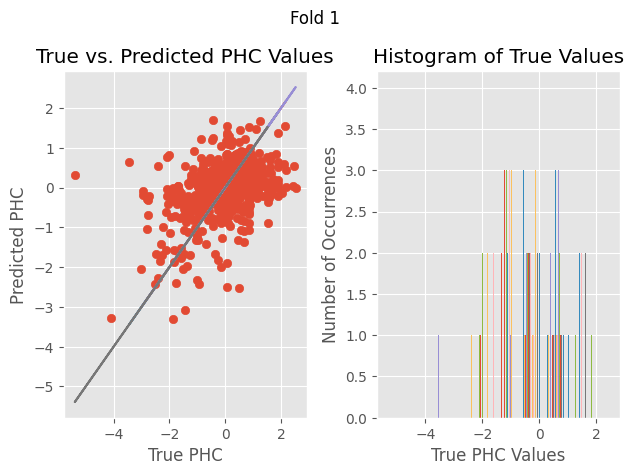

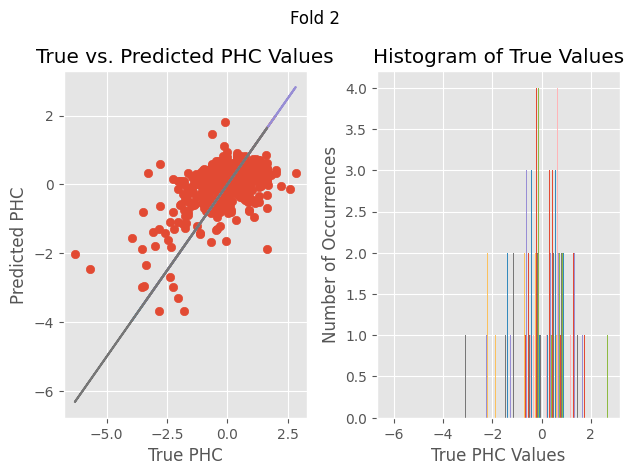

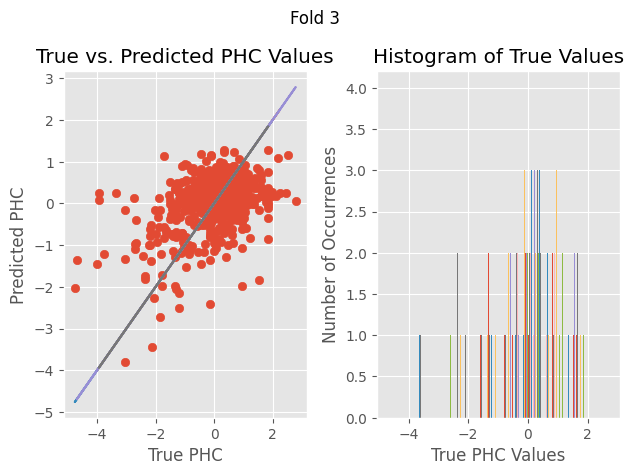

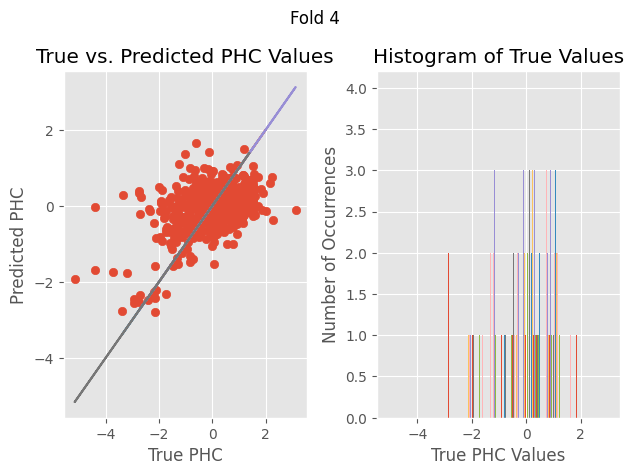

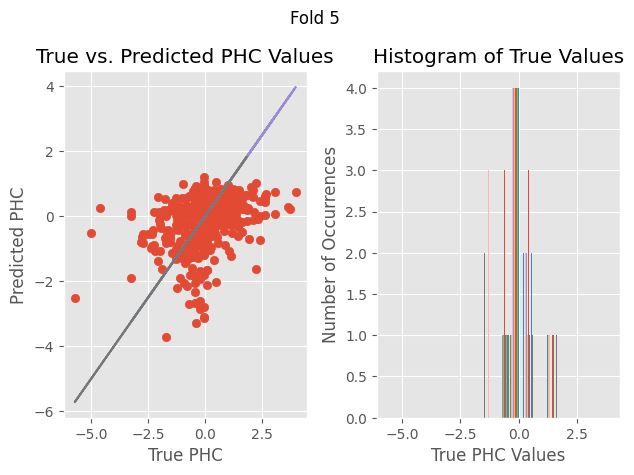

In [16]:
# Cross-Fold Validation: Ordered Setup
RMSE_NN_OS = np.zeros(5)
R2_OS = np.zeros(5)
for i in range(5):
  test_ds = test_folds_ord[i].apply(stats.zscore).fillna(0)
  train_ds = train_folds_ord[i].apply(stats.zscore).fillna(0)
  input_size = len(nr_features)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=nr_features, target_col=labels)
  test_pt_ds = PandasDataset(test_ds, feature_cols=nr_features, target_col=labels)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  cfv_nn_error += [train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)]
  cfv_nn_models.append(model)
  RMSE_NN_OS[i], R2_OS[i]= eval_model(model, test_dl, title_name="Fold "+ str((i+1)))
print(np.mean(RMSE_NN_OS))
print(np.mean(R2_OS))
print(R2_OS)
print(RMSE_NN_OS)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.9486491931336266
Epoch 5 loss 0.771431656394686
Epoch 10 loss 0.727483829004424
Epoch 15 loss 0.7142070186989647
Epoch 20 loss 0.6934025547334126
Epoch 25 loss 0.6851208835840226
Epoch 30 loss 0.6597902517233576
Epoch 35 loss 0.6591767085450037
Epoch 40 loss 0.6568913021257945
Epoch 45 loss 0.64102386704513
Epoch 50 loss 0.6333430843693869
Epoch 55 loss 0.6199791182364737
Epoch 60 loss 0.6344138839415141
Epoch 65 loss 0.6174311795404979
Epoch 70 loss 0.6076581767627172
Epoch 75 loss 0.6060982080442565
Epoch 80 loss 0.6107151372092111
Epoch 85 loss 0.5973652780056
Epoch 90 loss 0.5935873184885297
Epoch 95 loss 0.5850426544036184
Finished training!
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1): ReL

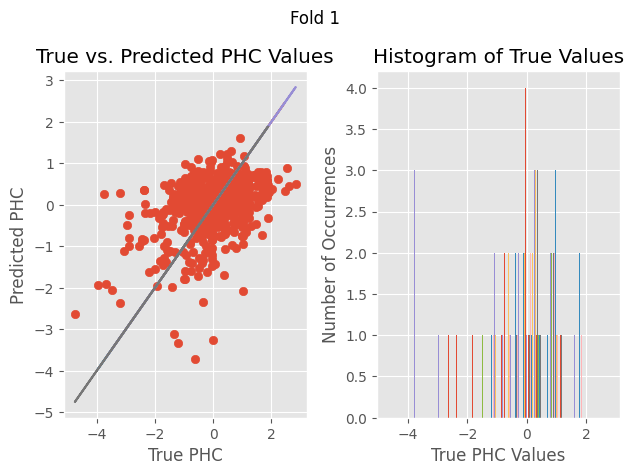

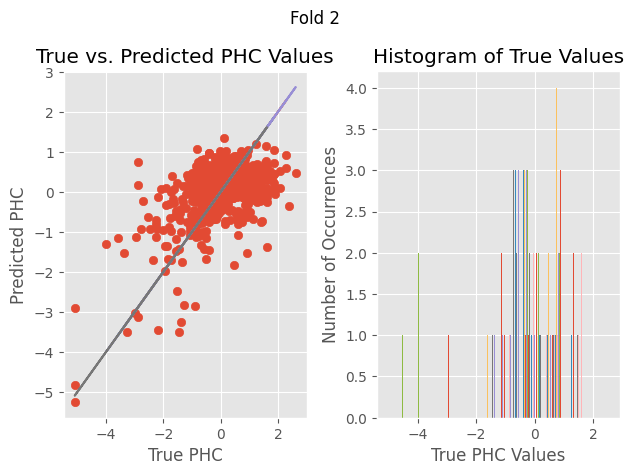

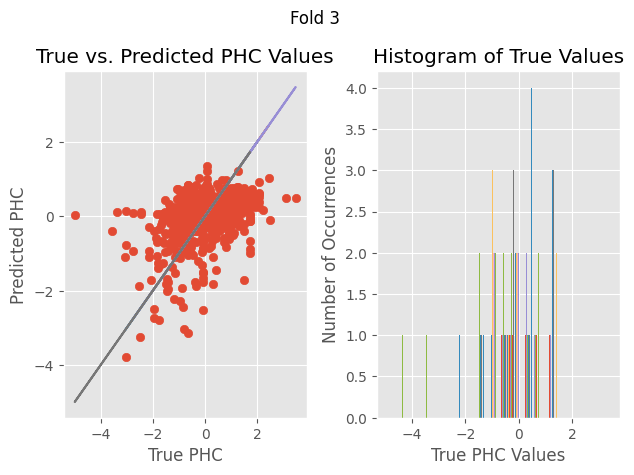

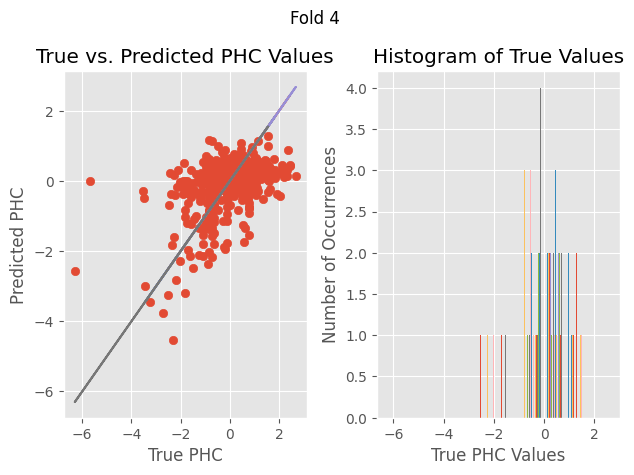

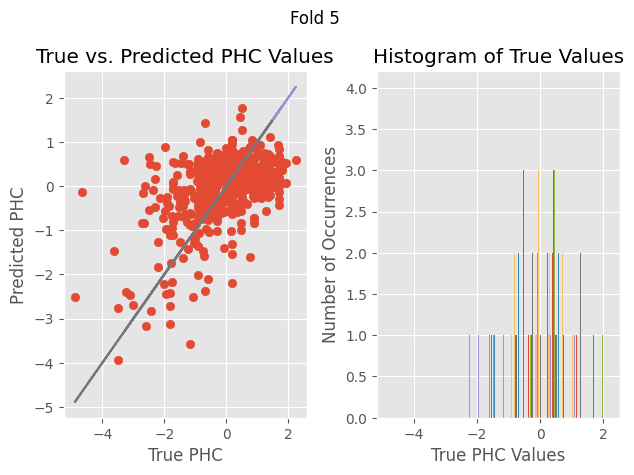

In [17]:
# Cross-Fold Validation: Randomized Setup
RMSE_NN_RS = np.zeros(5)
R2_RS = np.zeros(5)
for i in range(5):
  test_ds = test_folds_rand[i].apply(stats.zscore).fillna(0)
  train_ds = train_folds_rand[i].apply(stats.zscore).fillna(0)
  input_size = len(nr_features)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=nr_features, target_col=labels)
  test_pt_ds = PandasDataset(test_ds, feature_cols=nr_features, target_col=labels)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  cfv_nn_error += [train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)]
  cfv_nn_models.append(model)
  RMSE_NN_RS[i], R2_RS[i]= eval_model(model,test_dl, title_name="Fold "+ str((i+1)))
print(np.mean(RMSE_NN_RS))
print(np.mean(R2_RS))
print(R2_RS)
print(RMSE_NN_RS)

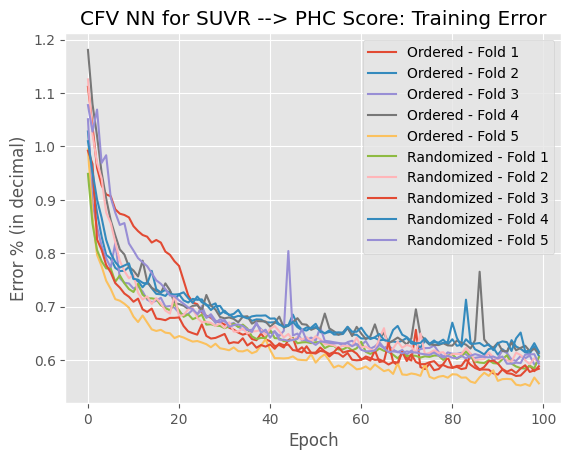

In [18]:
plt.figure()
for i in range(len(cfv_nn_error)):
  if i < 5:
    plt.plot(list(range(100)),cfv_nn_error[i],label="Ordered - Fold "+str(i+1))
  else:
    plt.plot(list(range(100)),cfv_nn_error[i],label="Randomized - Fold "+str(i-4))
plt.xlabel("Epoch")
plt.ylabel("Error % (in decimal)")
plt.title("CFV NN for SUVR --> PHC Score: Training Error")
plt.legend()

In [40]:
min_training_error = [min(x) for x in cfv_nn_error]
fold_nums = list(range(1,6))
fold_names = ["Ordered - Fold "+str(i) for i in fold_nums] + ["Randomized - Fold "+str(i) for i in fold_nums]

R2_CFV = np.concatenate((R2_OS, R2_RS))
RMSE_CFV = np.concatenate((RMSE_NN_OS, RMSE_NN_RS))

print("Minimum Training Error:")
for i in np.argsort(min_training_error):
    print(fold_names[i] + ": " + str(min_training_error[i]))

print()
print("Maximum R2 Score:")
for i in np.argsort(-R2_CFV):
    print(fold_names[i] + ": " + str(R2_CFV[i]))

print()
print("Minimum RMSE:")
for i in np.argsort(RMSE_CFV):
    print(fold_names[i] + ": " + str(RMSE_CFV[i]))

Minimum Training Error:
Ordered - Fold 5: 0.5517168590000697
Ordered - Fold 1: 0.5703733222825187
Randomized - Fold 3: 0.5759309247136116
Randomized - Fold 1: 0.5842091890318053
Ordered - Fold 3: 0.5918895325490406
Randomized - Fold 2: 0.5924335237060274
Randomized - Fold 5: 0.5933398949248451
Ordered - Fold 2: 0.6077276305428573
Ordered - Fold 4: 0.61310061602188
Randomized - Fold 4: 0.6157398049320494

Maximum R2 Score:
Ordered - Fold 2: 1.3059980882877418
Ordered - Fold 4: 0.8474163525091718
Ordered - Fold 5: 0.7396386211313812
Ordered - Fold 1: 0.48432226068739304
Ordered - Fold 3: 0.45710894457085205
Randomized - Fold 2: 0.2569361146698327
Randomized - Fold 5: 0.20540746396509355
Randomized - Fold 4: 0.16168884967507444
Randomized - Fold 1: 0.09052503836162362
Randomized - Fold 3: 0.08025617316521425

Minimum RMSE:
Ordered - Fold 2: 0.7217463254928589
Randomized - Fold 2: 0.7430639266967773
Randomized - Fold 5: 0.7945926189422607
Ordered - Fold 4: 0.7993389964103699
Randomized - F

In [29]:
cfv_nn_error_nz = []
cfv_nn_models_nz = []

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.6195099558149065
Epoch 5 loss 0.3377186249409403
Epoch 10 loss 0.3146957666746208
Epoch 15 loss 0.3023614386761827
Epoch 20 loss 0.29354632922581264
Epoch 25 loss 0.2840303480492106
Epoch 30 loss 0.2850602423905262
Epoch 35 loss 0.29474932019199646
Epoch 40 loss 0.27782761827111246
Epoch 45 loss 0.2772468559976135
Epoch 50 loss 0.2680360071893249
Epoch 55 loss 0.2737613881272929
Epoch 60 loss 0.26967780494264193
Epoch 65 loss 0.26325558722019193
Epoch 70 loss 0.2681244493595191
Epoch 75 loss 0.262459848182542
Epoch 80 loss 0.2607539053474154
Epoch 85 loss 0.26707369302000317
Epoch 90 loss 0.2603897784437452
Epoch 95 loss 0.259704253077507
Finished training!
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
 

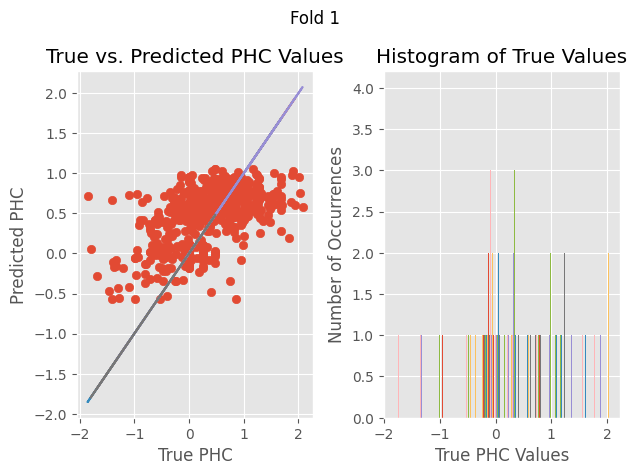

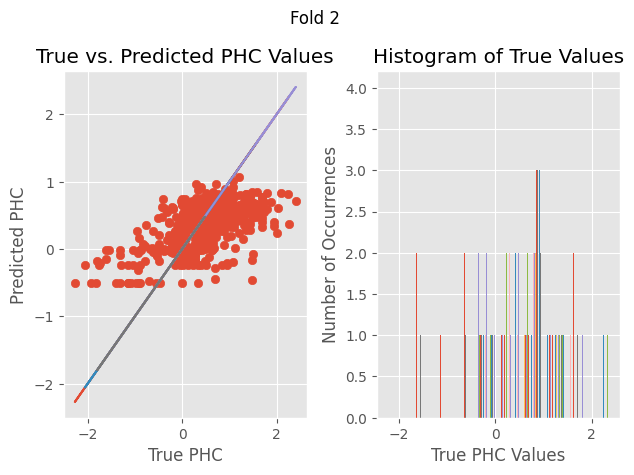

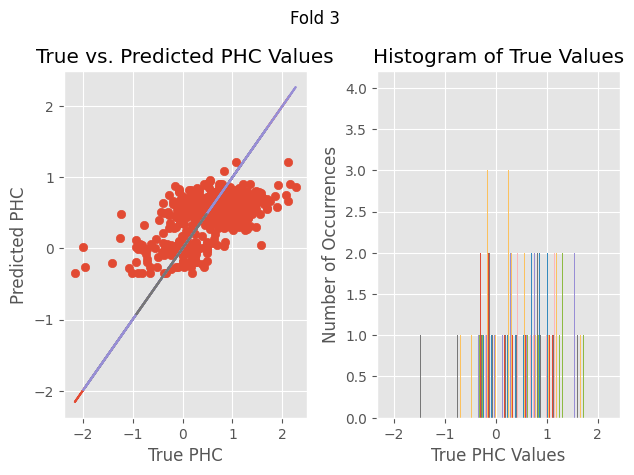

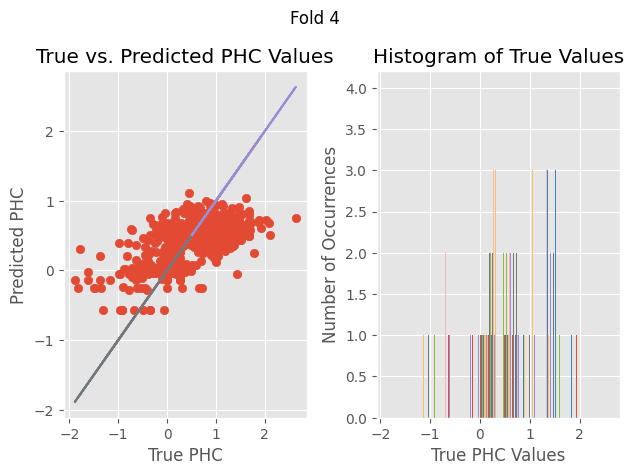

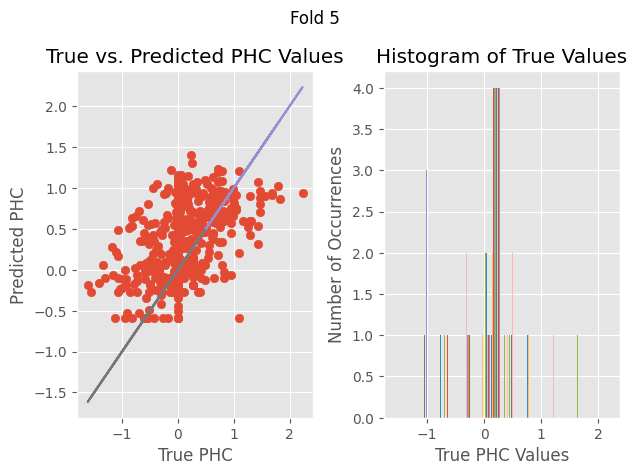

In [30]:
# Cross-Fold Validation: Ordered Setup (No ZScore)
RMSE_NN_OS_NZ = np.zeros(5)
R2_OS_NZ = np.zeros(5)
for i in range(5):
  test_ds = test_folds_ord[i].fillna(0)
  train_ds = train_folds_ord[i].fillna(0)
  input_size = len(nr_features)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=nr_features, target_col=labels)
  test_pt_ds = PandasDataset(test_ds, feature_cols=nr_features, target_col=labels)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  cfv_nn_error_nz += [train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)]
  cfv_nn_models_nz.append(model)
  RMSE_NN_OS_NZ[i], R2_OS_NZ[i]= eval_model(model, test_dl, title_name="Fold "+ str((i+1)))

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.3943509574447359
Epoch 5 loss 0.33314223869570664
Epoch 10 loss 0.3216856744672571
Epoch 15 loss 0.29660722102437703
Epoch 20 loss 0.28387007415294646
Epoch 25 loss 0.27561701429741725
Epoch 30 loss 0.2744598842092923
Epoch 35 loss 0.2698164161826883
Epoch 40 loss 0.2731511765292713
Epoch 45 loss 0.26549350379833153
Epoch 50 loss 0.27100363820791246
Epoch 55 loss 0.26466025255088294
Epoch 60 loss 0.27007324056965964
Epoch 65 loss 0.26440918695713794
Epoch 70 loss 0.2696696781686374
Epoch 75 loss 0.26110720496092527
Epoch 80 loss 0.2614021397395326
Epoch 85 loss 0.2711009592882225
Epoch 90 loss 0.27016456701925823
Epoch 95 loss 0.2620835888864739
Finished training!
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=116, out_features=4, bias=

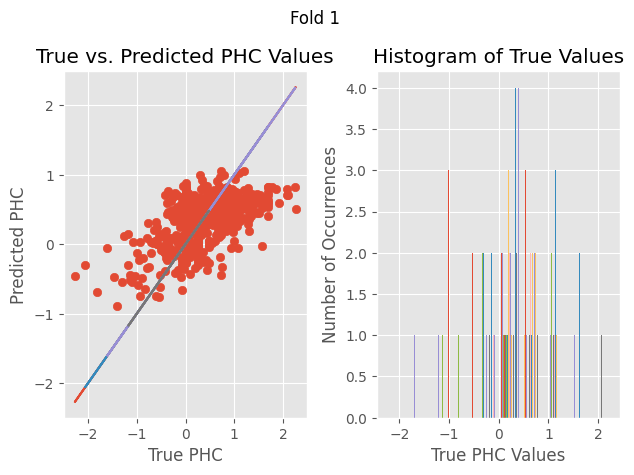

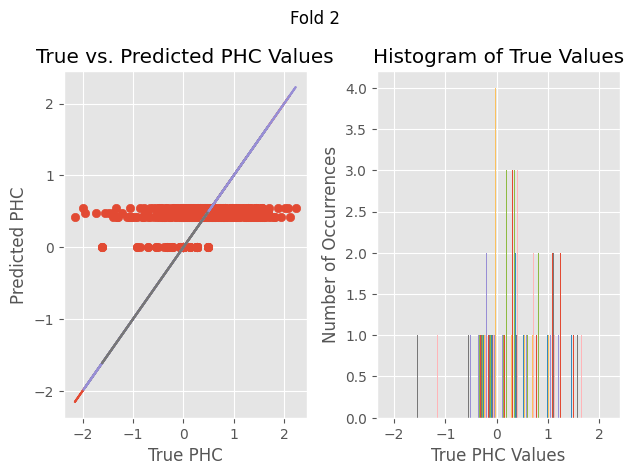

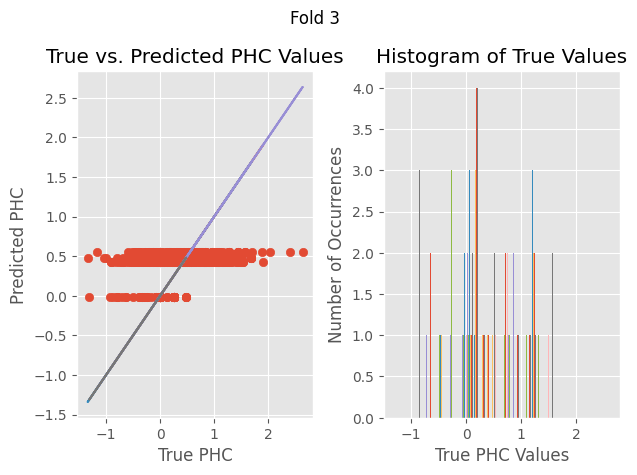

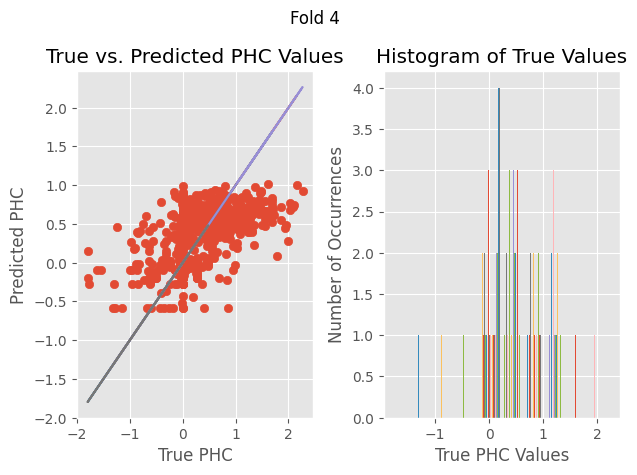

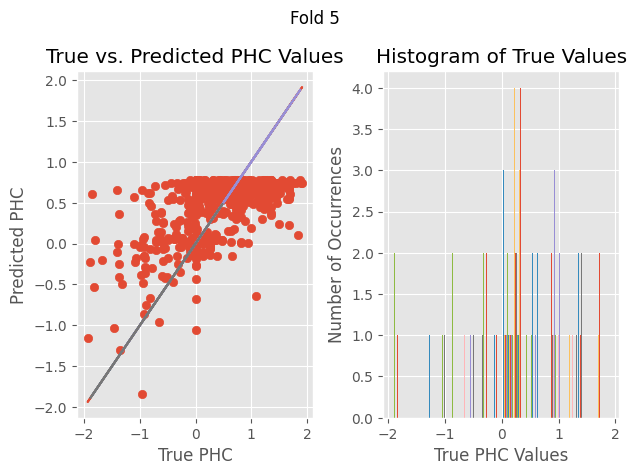

In [31]:
# Cross-Fold Validation: Randomized Setup
RMSE_NN_RS_NZ = np.zeros(5)
R2_RS_NZ = np.zeros(5)
for i in range(5):
  test_ds = test_folds_rand[i].fillna(0)
  train_ds = train_folds_rand[i].fillna(0)
  input_size = len(nr_features)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=nr_features, target_col=labels)
  test_pt_ds = PandasDataset(test_ds, feature_cols=nr_features, target_col=labels)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  cfv_nn_error_nz += [train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)]
  cfv_nn_models_nz.append(model)
  RMSE_NN_RS_NZ[i], R2_RS_NZ[i]= eval_model(model,test_dl, title_name="Fold "+ str((i+1)))

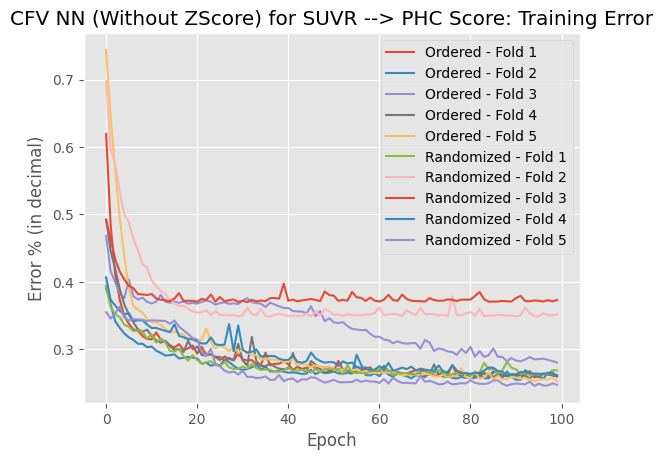

In [34]:
plt.figure()
for i in range(len(cfv_nn_error_nz)):
  if i < 5:
    plt.plot(list(range(100)),cfv_nn_error_nz[i],label="Ordered - Fold "+str(i+1))
  else:
    plt.plot(list(range(100)),cfv_nn_error_nz[i],label="Randomized - Fold "+str(i-4))
plt.xlabel("Epoch")
plt.ylabel("Error % (in decimal)")
plt.title("CFV NN (Without ZScore) for SUVR --> PHC Score: Training Error")
plt.legend()

In [42]:
min_training_error_nz = [min(x) for x in cfv_nn_error_nz]
fold_names_nz = ["Ordered NZ - Fold "+str(i) for i in fold_nums] + ["Randomized NZ - Fold "+str(i) for i in fold_nums]

R2_CFV_NZ = np.concatenate((R2_OS_NZ, R2_RS_NZ))
RMSE_CFV_NZ = np.concatenate((RMSE_NN_OS_NZ, RMSE_NN_RS_NZ))

print("Minimum Training Error:")
for i in np.argsort(min_training_error_nz):
    print(fold_names_nz[i] + ": " + str(min_training_error_nz[i]))

print()
print("Maximum R2 Score:")
for i in np.argsort(-R2_CFV_NZ):
    print(fold_names_nz[i] + ": " + str(R2_CFV_NZ[i]))

print()
print("Minimum RMSE:")
for i in np.argsort(RMSE_CFV_NZ):
    print(fold_names_nz[i] + ": " + str(RMSE_CFV_NZ[i]))

Minimum Training Error:
Randomized NZ - Fold 5: 0.24554618724754879
Ordered NZ - Fold 5: 0.25276622772216795
Ordered NZ - Fold 2: 0.25458868518471717
Ordered NZ - Fold 4: 0.2566709025097745
Ordered NZ - Fold 1: 0.25815238643969807
Randomized NZ - Fold 4: 0.2596049362793565
Randomized NZ - Fold 1: 0.26110720496092527
Ordered NZ - Fold 3: 0.28019413660679543
Randomized NZ - Fold 2: 0.3482836446259171
Randomized NZ - Fold 3: 0.36983530768858536

Maximum R2 Score:
Randomized NZ - Fold 5: 0.2256437333791128
Randomized NZ - Fold 4: 0.20699635975161346
Ordered NZ - Fold 4: 0.1940598352836639
Ordered NZ - Fold 2: 0.17820796994826776
Ordered NZ - Fold 3: 0.17226887674123645
Randomized NZ - Fold 1: 0.1702678411498943
Ordered NZ - Fold 1: 0.16321944916479467
Randomized NZ - Fold 2: -0.0026146945742243077
Randomized NZ - Fold 3: -0.005284477029845802
Ordered NZ - Fold 5: -0.5025292837067592

Minimum RMSE:
Ordered NZ - Fold 3: 0.22157539427280426
Randomized NZ - Fold 1: 0.2570430338382721
Randomize

In [43]:
min_training_error_all = min_training_error + min_training_error_nz
fold_names_all = fold_names + fold_names_nz

r2_cfv_all = np.concatenate((R2_CFV, R2_CFV_NZ))
rmse_cfv_all = np.concatenate((RMSE_CFV, RMSE_CFV_NZ))

print("Minimum Training Error:")
for i in np.argsort(min_training_error_all):
    print(fold_names_all[i] + ": " + str(min_training_error_all[i]))

print()
print("Maximum R2 Score:")
for i in np.argsort(-r2_cfv_all):
    print(fold_names_all[i] + ": " + str(r2_cfv_all[i]))

print()
print("Minimum RMSE:")
for i in np.argsort(rmse_cfv_all):
    print(fold_names_all[i] + ": " + str(rmse_cfv_all[i]))

Minimum Training Error:
Randomized NZ - Fold 5: 0.24554618724754879
Ordered NZ - Fold 5: 0.25276622772216795
Ordered NZ - Fold 2: 0.25458868518471717
Ordered NZ - Fold 4: 0.2566709025097745
Ordered NZ - Fold 1: 0.25815238643969807
Randomized NZ - Fold 4: 0.2596049362793565
Randomized NZ - Fold 1: 0.26110720496092527
Ordered NZ - Fold 3: 0.28019413660679543
Randomized NZ - Fold 2: 0.3482836446259171
Randomized NZ - Fold 3: 0.36983530768858536
Ordered - Fold 5: 0.5517168590000697
Ordered - Fold 1: 0.5703733222825187
Randomized - Fold 3: 0.5759309247136116
Randomized - Fold 1: 0.5842091890318053
Ordered - Fold 3: 0.5918895325490406
Randomized - Fold 2: 0.5924335237060274
Randomized - Fold 5: 0.5933398949248451
Ordered - Fold 2: 0.6077276305428573
Ordered - Fold 4: 0.61310061602188
Randomized - Fold 4: 0.6157398049320494

Maximum R2 Score:
Ordered - Fold 2: 1.3059980882877418
Ordered - Fold 4: 0.8474163525091718
Ordered - Fold 5: 0.7396386211313812
Ordered - Fold 1: 0.48432226068739304
Ord

In [47]:
cfv_nn_models_all = cfv_nn_models + cfv_nn_models_nz

best_rmse_cfv_nn_model = cfv_nn_models_all[np.argsort(rmse_cfv_all)[0]]
print("Best RMSE Model: " + fold_names_all[np.argsort(rmse_cfv_all)[0]])

best_r2_cfv_nn_model = cfv_nn_models_all[np.argsort(-r2_cfv_all)[0]]
print("Best R2 Model: " + fold_names_all[np.argsort(-r2_cfv_all)[0]])

testing_rankings = []
for i in range(len(cfv_nn_models_all)):
    testing_rankings.append((np.where(np.argsort(rmse_cfv_all) == i)[0][0] + np.where(np.argsort(-r2_cfv_all) == i)[0][0] )/2)

best_testing_cfv_nn_model = cfv_nn_models_all[np.argsort(testing_rankings)[0]]
print("Best Testing Model: " + fold_names_all[np.argsort(testing_rankings)[0]])


Best RMSE Model: Ordered NZ - Fold 3
Best R2 Model: Ordered - Fold 2
Best Testing Model: Randomized NZ - Fold 4


In [53]:
model_name = fold_names_all[np.argsort(testing_rankings)[0]]
if ("NZ" in model_name):
    train_ds = os_df.fillna(0)
else:
    train_ds = os_df.apply(stats.zscore).fillna(0)
input_size = len(nr_features)
batch_size = 10
train_pt_ds = PandasDataset(train_ds, feature_cols=nr_features, target_col=labels)
train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
learning_rate = 0.001
nr_epochs = 5000
eval_every = 100
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(best_testing_cfv_nn_model.parameters(), lr=learning_rate)
cfv_nn_error_final = [train_model(best_testing_cfv_nn_model, train_dl, optimizer, loss_f, nr_epochs, eval_every)]

Epoch 0 loss 0.24459075482412315
Epoch 100 loss 0.24351026417537666
Epoch 200 loss 0.25017023891553114
Epoch 300 loss 0.24611155269132262
Epoch 400 loss 0.24323775447990703
Epoch 500 loss 0.2469436739539278
Epoch 600 loss 0.24659506848146176
Epoch 700 loss 0.246929835399677
Epoch 800 loss 0.24684802973749995
Epoch 900 loss 0.2418538743908378
Epoch 1000 loss 0.24130313252580576
Epoch 1100 loss 0.2425086864794808
Epoch 1200 loss 0.2520304303402188
Epoch 1300 loss 0.2445926971134098
Epoch 1400 loss 0.2404127692182859
Epoch 1500 loss 0.238298410314253
Epoch 1600 loss 0.24027088969603352
Epoch 1700 loss 0.24181628415639372
Epoch 1800 loss 0.23949771717019464
Epoch 1900 loss 0.23930597776311568
Epoch 2000 loss 0.24482739194371234
Epoch 2100 loss 0.24012756142122993
Epoch 2200 loss 0.23746771553809615
Epoch 2300 loss 0.24145494684063154
Epoch 2400 loss 0.23965093990166983
Epoch 2500 loss 0.23937477830840254
Epoch 2600 loss 0.24204273179344749
Epoch 2700 loss 0.24547560230411333
Epoch 2800 los

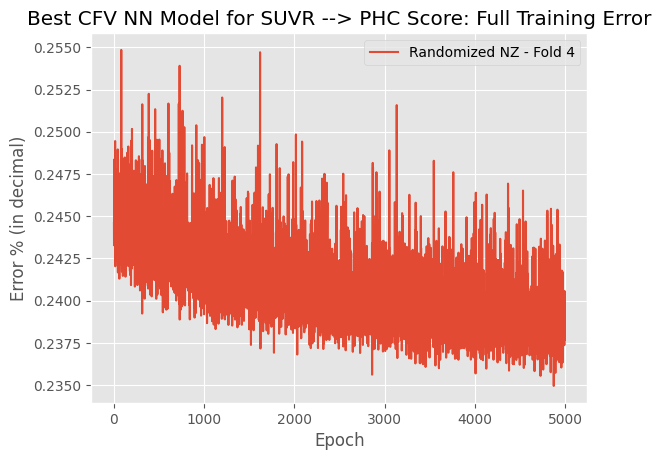

In [54]:
plt.figure()
plt.plot(list(range(5000)),np.reshape(cfv_nn_error_final, (5000,)),label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Error % (in decimal)")
plt.title("Best CFV NN Model for SUVR --> PHC Score: Full Training Error")
plt.legend()

0.237713 0.27871604241450515


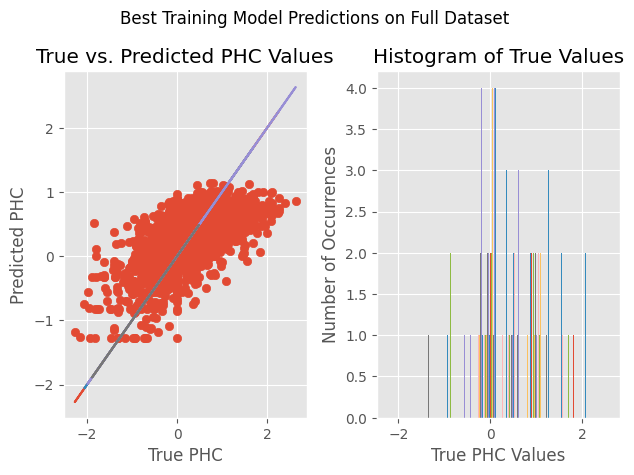

In [55]:
rmse_cfv_nn_final, r2_cfv_nn_final= eval_model(best_testing_cfv_nn_model,train_dl, title_name="Best Training Model Predictions on Full Dataset")
print(rmse_cfv_nn_final, r2_cfv_nn_final)


### SVM Implementation

In [11]:
import warnings

warnings.filterwarnings("ignore")

0.3550665215726102
-0.0683755974968466
[0.35328858 0.39876313 0.36230005 0.38126427 0.27971658]
[ 0.01913829 -0.03314467 -0.16092479  0.03080623 -0.19775304]


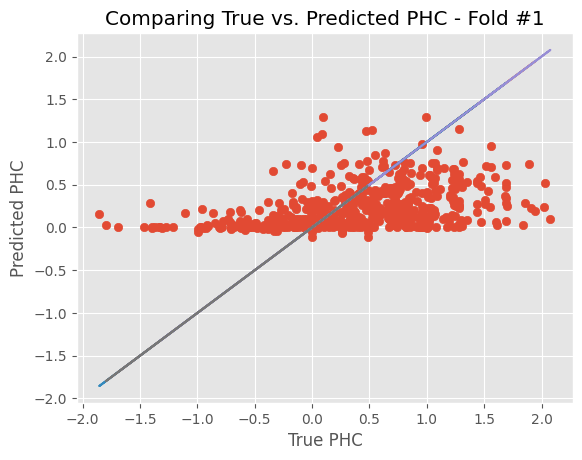

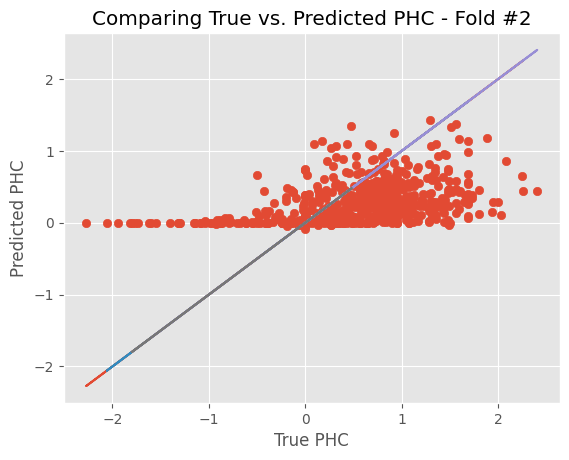

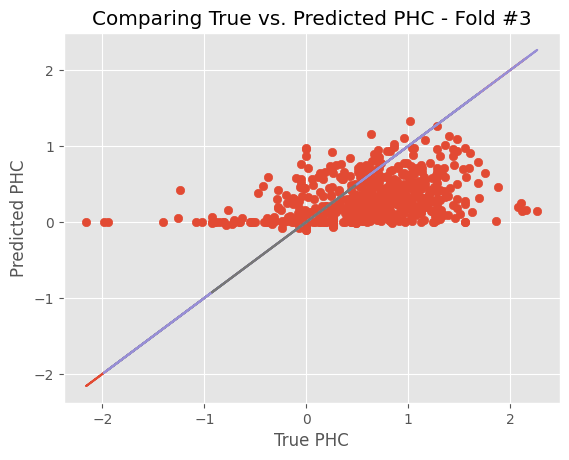

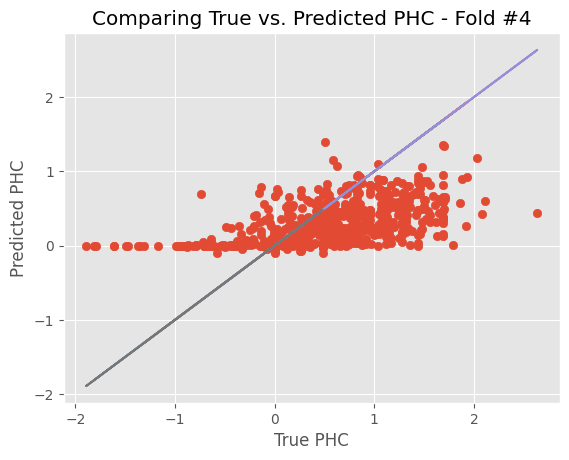

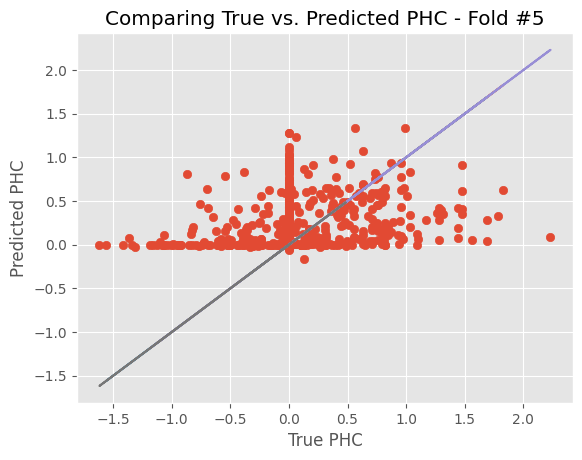

In [38]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('PHC')
  feature_columns = df.columns.str.contains('_SUVR')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  R2[i] = r2_score(out_test,testPred)
  RMSE_SVM[i]= rmse(out_test,testPred)
  plt.figure ()
  plt.plot(out_test,out_test)
  plt.scatter(out_test,testPred)
  plt.xlabel("True PHC")
  plt.ylabel("Predicted PHC")
  fold_num = i+1
  plt.title("Comparing True vs. Predicted PHC - Fold #" + str(fold_num))
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

## ROI Volume --> SUVR Scores

ROI to SUVR In a fully connected Manner but later discovered this was not a good implementation.

New Neural Network implementation for this application

['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL_SUVR', 'CTX_LH_POSTERIORCI

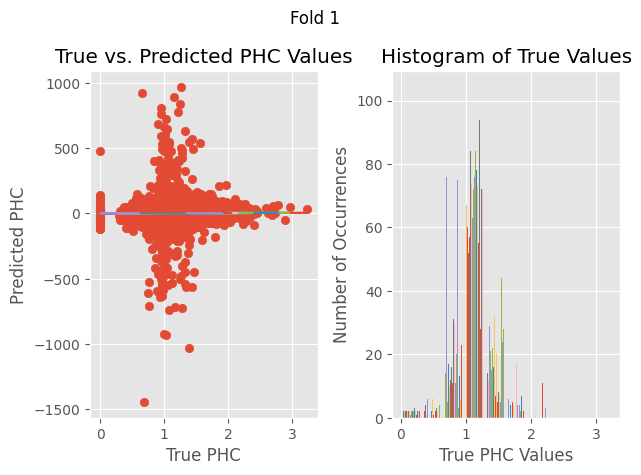

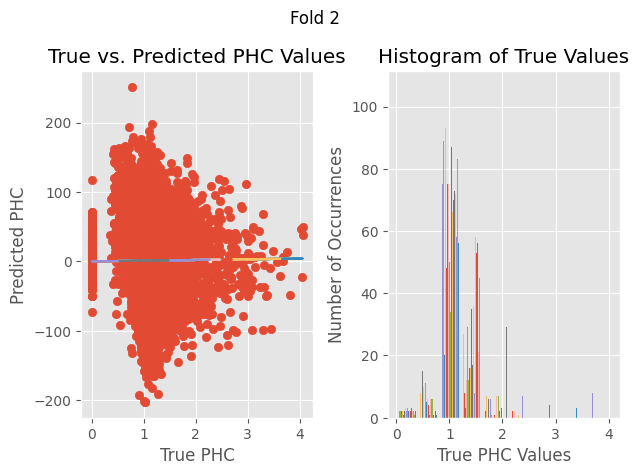

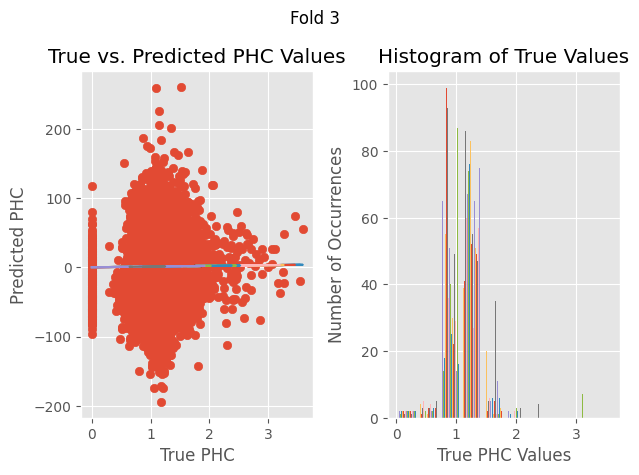

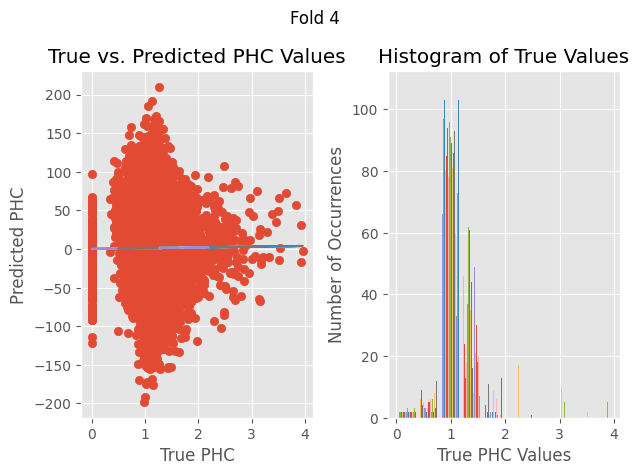

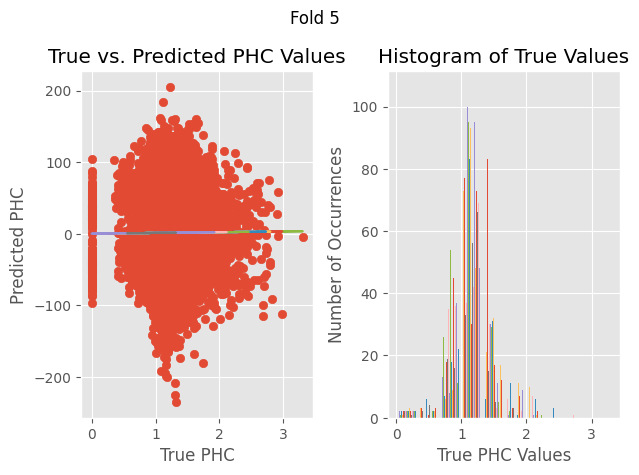

In [16]:
df = adni_tau_nr_basic_df.copy().fillna(0)
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size =116
  out_columns = df.columns.str.contains('_SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,nr_classes=116,hidden_layer_sizes=[116])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl, title_name="Fold "+ str((i+1)))
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(RMSE_NN)
print(R2)

SVM Implementation

In [17]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

1.130379032064647
-77.90426199342252
[1.12179062 1.15309651 1.10901984 1.11615788 1.15183031]
[-92.86984346 -64.7701054  -86.64888009 -71.11888058 -74.11360045]


## ROI Volume & PHC Score --> SUVR

### Understanding the Potential Confounding Variables

In [21]:
from collections import Counter

# Adjust labels to start from 0

# Print label classes and counts
print(Counter(adni_tau_df['PTGENDER']))

Counter({2: 438, 1: 426})


In [22]:
print(adni_tau_df['age'].mean())

73.85413339417447


In [24]:
print(adni_tau_df['age'].max())

94.4394250513347


In [23]:
print(adni_tau_df['age'].min())

55.2772073921971


First a Pearson Correlation test to see if there is any significance in the correlation of the volume scores and the confounding variables of age and gender

In [25]:
print(stats.pearsonr(adni_tau_df['CTX_LH_PRECENTRAL_VOLUME'] , adni_tau_df['age']))

PearsonRResult(statistic=-0.20565926414311791, pvalue=1.0493879204944676e-09)


In [26]:
print(stats.pearsonr(adni_tau_df['CTX_LH_PRECENTRAL_VOLUME'] , adni_tau_df['PTGENDER']))

PearsonRResult(statistic=-0.3230689035548924, pvalue=1.9375796349714244e-22)


In [27]:
print(stats.pearsonr(adni_tau_df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , adni_tau_df['PTGENDER']))

PearsonRResult(statistic=-0.3990053240183068, pvalue=2.3542522303584707e-34)


In [28]:
print(stats.pearsonr(adni_tau_df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , adni_tau_df['age']))

PearsonRResult(statistic=-0.16396929275450722, pvalue=1.2626318692776486e-06)


In [29]:
print(stats.pearsonr(adni_tau_df['CTX_RH_TEMPORALPOLE_VOLUME'] , adni_tau_df['age']))

PearsonRResult(statistic=-0.05631959614097619, pvalue=0.09805279358418464)


In [30]:
print(stats.pearsonr(adni_tau_df['CTX_RH_TEMPORALPOLE_VOLUME'] , adni_tau_df['age']))

PearsonRResult(statistic=-0.05631959614097619, pvalue=0.09805279358418464)


In [32]:
print(stats.pearsonr(adni_tau_df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , adni_tau_df['PTGENDER']))

PearsonRResult(statistic=-0.317270616701127, pvalue=1.1730624276306434e-21)


In [31]:
print(stats.pearsonr(adni_tau_df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , adni_tau_df['age']))

PearsonRResult(statistic=-0.22705286028804894, pvalue=1.4513217485712892e-11)


### Predicting CTX_LH_PRECENTRAL SUVR

#### Using the Memory (MEM) PHC Score

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.4569683074951172
Epoch 5 loss 0.5093866382326399
Epoch 10 loss 0.0807685454509088
Epoch 15 loss 0.020122197795925396
Epoch 20 loss 0.01663566927724917
Epoch 25 loss 0.016603103399808916
Epoch 30 loss 0.016648957010225524
Epoch 35 loss 0.016567091550678016
Epoch 40 loss 0.01667618343074407
Epoch 45 loss 0.017226006582911527
Epoch 50 loss 0.018204333373744573
Epoch 55 loss 0.01683227893330955
Epoch 60 loss 0.016796837298066487
Epoch 65 loss 0.01667050535324961
Epoch 70 loss 0.01677162449507575
Epoch 75 loss 0.016876744545464006
Epoch 80 loss 0.01657499311924247
Epoch 85 loss 0.01658932314853051
Epoch 90 loss 0.01661540113189923
Epoch 95 loss 0.016609668336708898
Finished training!


ValueError: x and y must be the same size

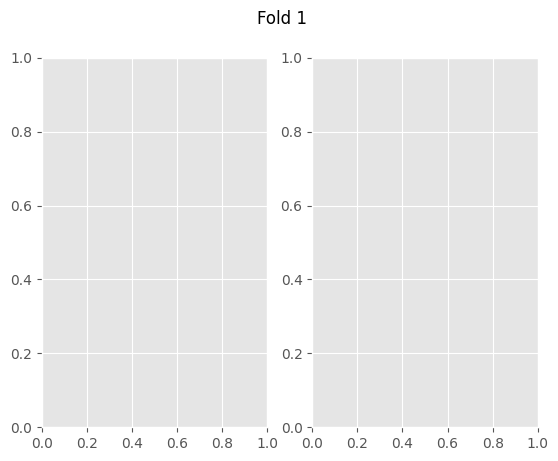

In [35]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i] = eval_model(model,test_dl, title_name="Fold "+ str((i+1)))
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

#### Using only ROI Volume

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.6533716934067862
Epoch 5 loss 0.1515953814876931
Epoch 10 loss 0.018279208106520985
Epoch 15 loss 0.0176567702088505
Epoch 20 loss 0.017597750451282732
Epoch 25 loss 0.01766408551151731
Epoch 30 loss 0.017606015144182103
Epoch 35 loss 0.017949261499701868
Epoch 40 loss 0.017651363843054112
Epoch 45 loss 0.01764802054967731
Epoch 50 loss 0.01759173199201801
Epoch 55 loss 0.017688502125175937
Epoch 60 loss 0.017624023698070753
Epoch 65 loss 0.017619363017313715
Epoch 70 loss 0.017605229438881258
Epoch 75 loss 0.01762730146292597
Epoch 80 loss 0.01773838508109163
Epoch 85 loss 0.017557739744162453
Epoch 90 loss 0.017738059154778187
Epoch 95 loss 0.017662495733903986
Finished training!
['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layer

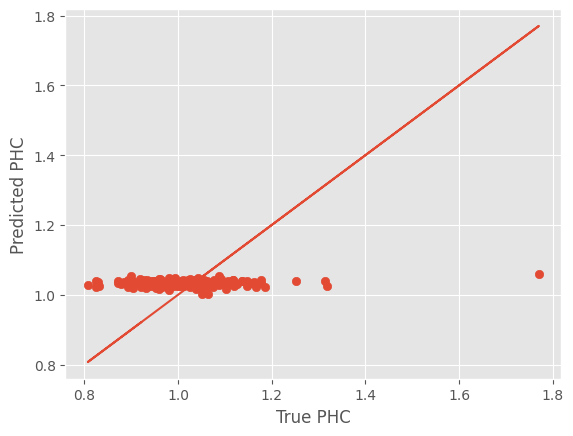

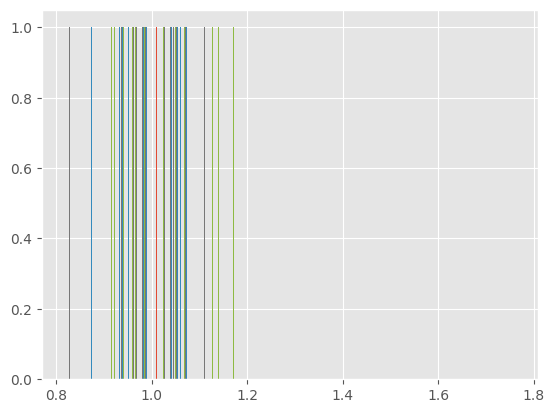

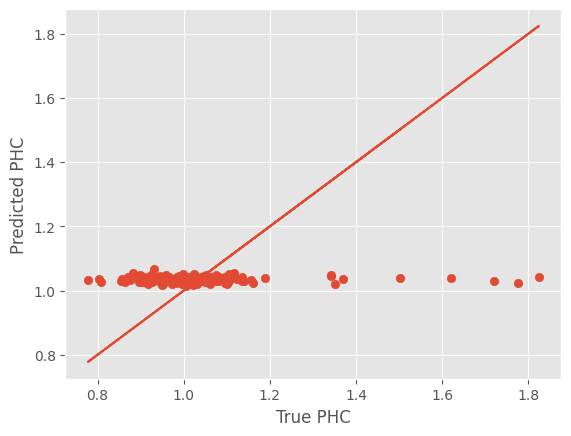

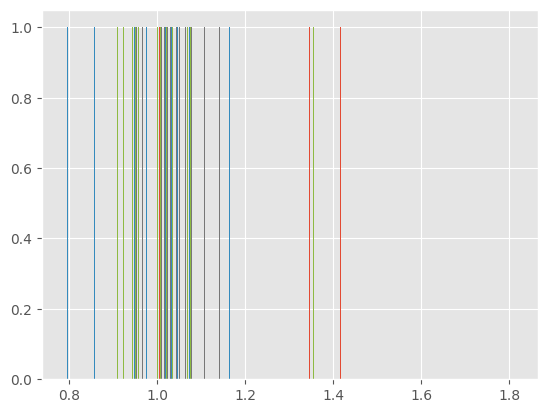

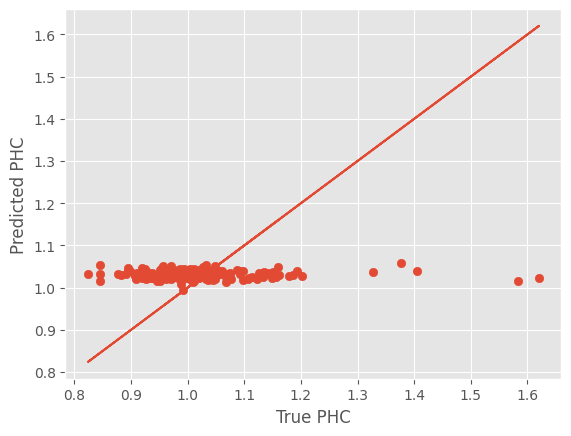

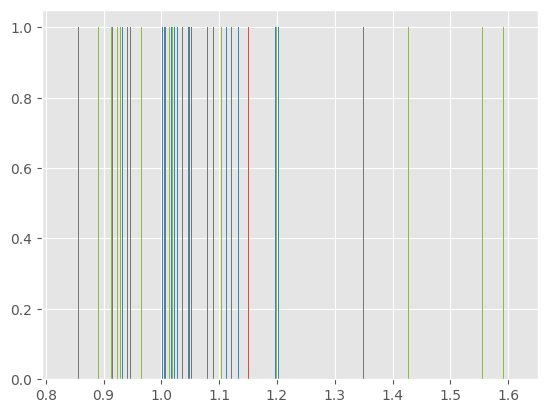

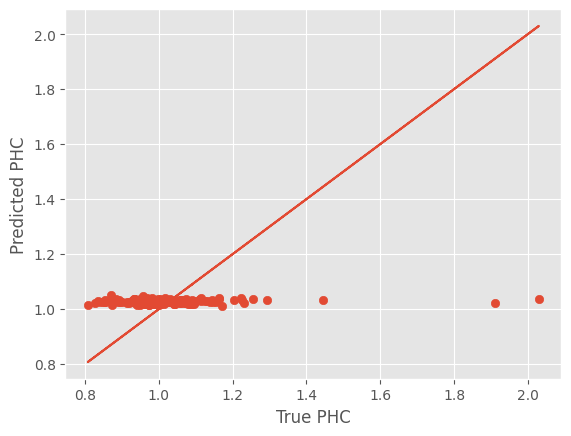

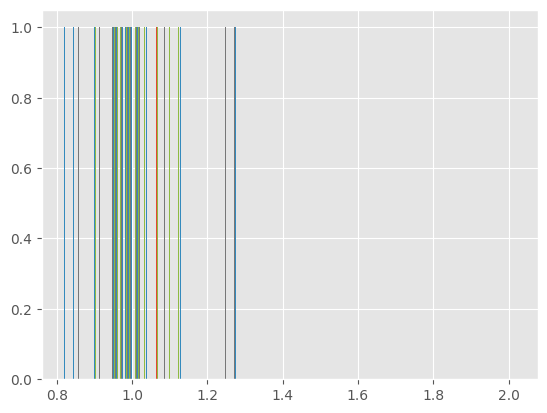

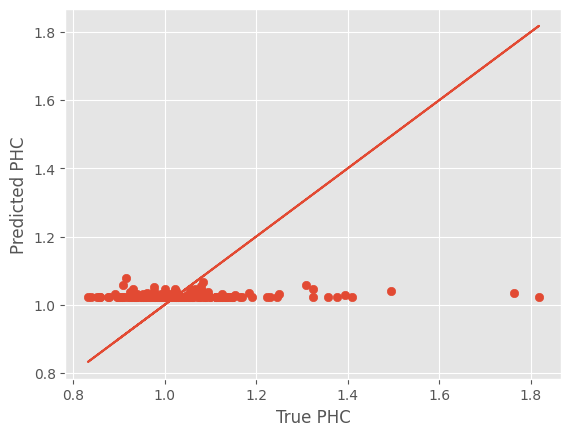

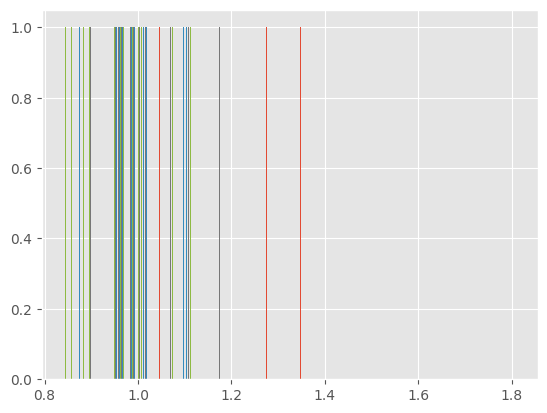

In [56]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

Here, we developed a single input of an ROI Volume rather than a fully connected network that allows cross talk between different ROIs. This allows a one to one relationship with an ROI Volume and its corresponding SUVR score.

### Predicting RIGHT_CEREBELLUM_CORTEX

#### Using Executive Function (EXF) PHC Score

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.4466355408940996
Epoch 5 loss 0.16914196056979044
Epoch 10 loss 0.0035893107165715526
Epoch 15 loss 0.0006577855887631553
Epoch 20 loss 0.0006482251273285198
Epoch 25 loss 0.0006480470118861246
Epoch 30 loss 0.0006545304266702649
Epoch 35 loss 0.0006618649962287496
Epoch 40 loss 0.0006495313572356411
Epoch 45 loss 0.0006466827718148644
Epoch 50 loss 0.0006481239395465569
Epoch 55 loss 0.0006514194920392973
Epoch 60 loss 0.0006515541104558256
Epoch 65 loss 0.0006466805753007066
Epoch 70 loss 0.0006545412807359494
Epoch 75 loss 0.0006642841810909366
Epoch 80 loss 0.0006572317837188685
Epoch 85 loss 0.0006618057063730833
Epoch 90 loss 0.0006683855003627417
Epoch 95 loss 0.000661051737967812
Finished training!
['RIGHT_CEREBELLUM_CORTEX

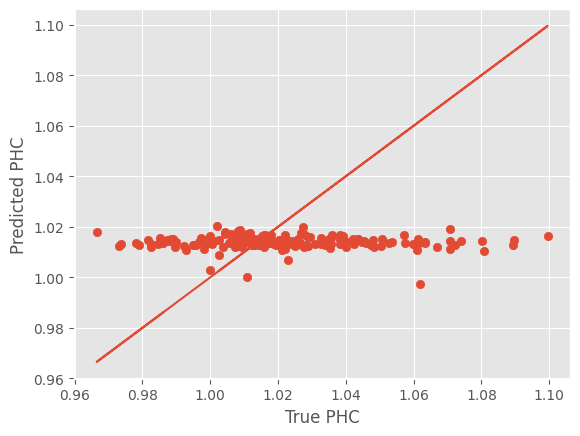

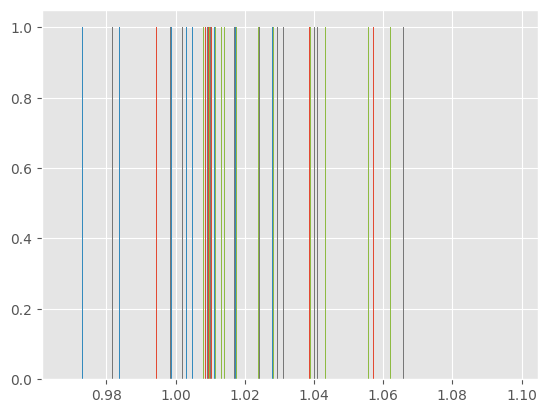

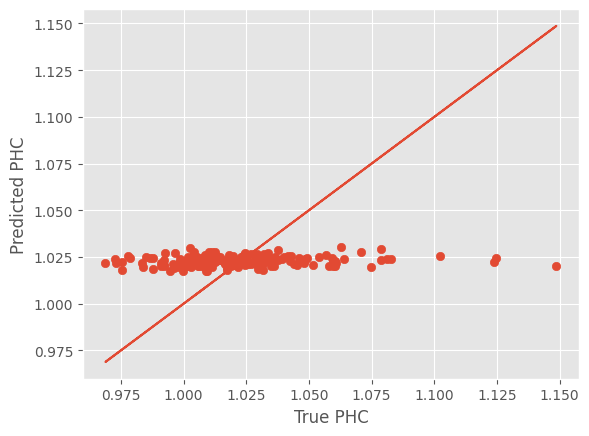

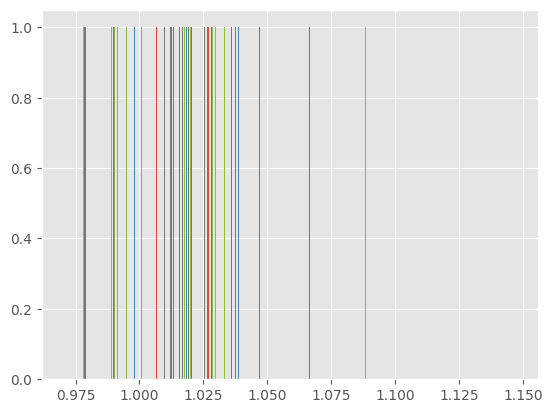

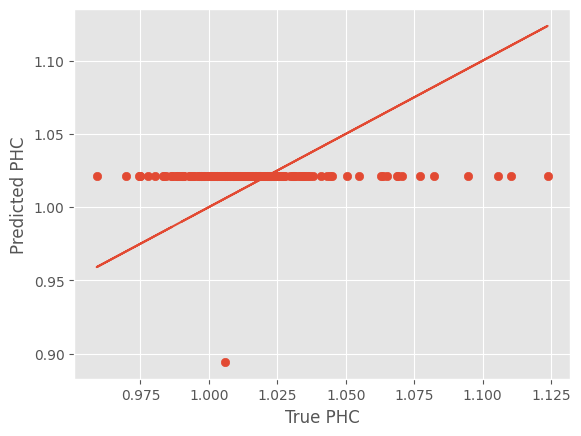

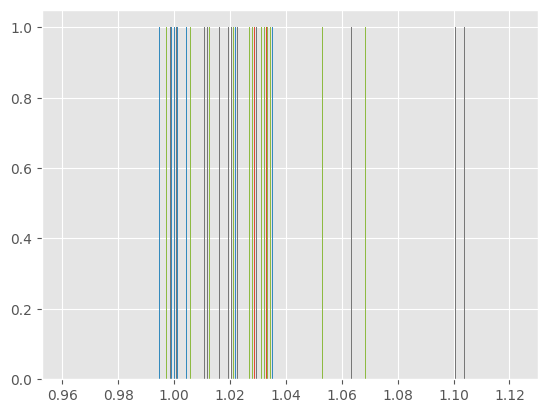

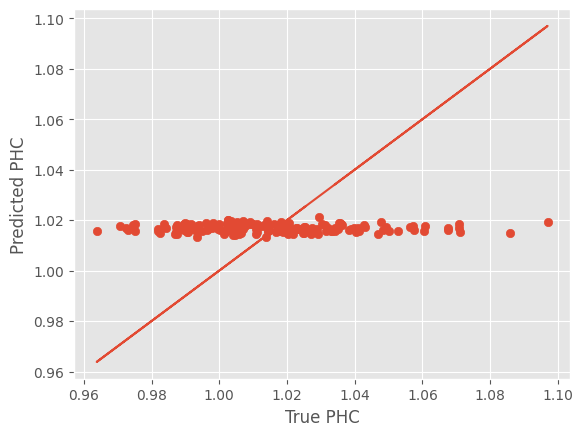

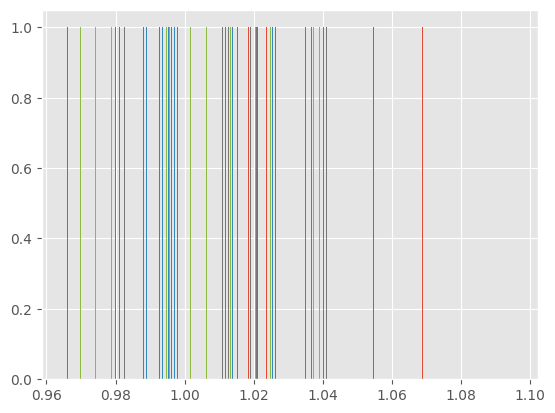

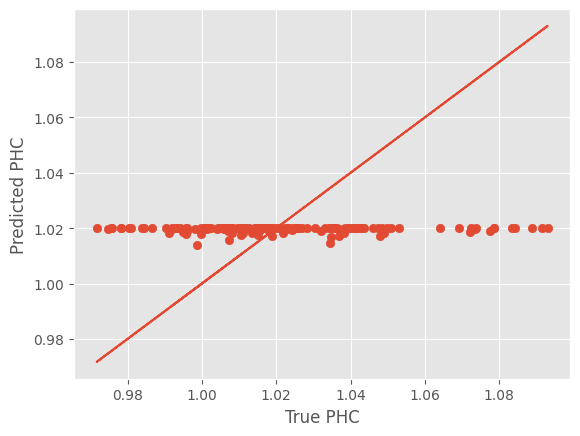

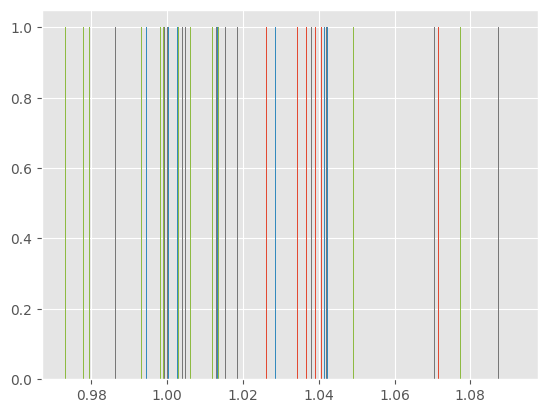

In [57]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
df['PHC_EXF_mannualJoin'] = stats.zscore(df['PHC_EXF_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

#### Using only ROI Volume

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.9056170327322823
Epoch 5 loss 0.11758490659828696
Epoch 10 loss 0.003096956992521882
Epoch 15 loss 0.0006581003526142532
Epoch 20 loss 0.0006462831966928207
Epoch 25 loss 0.0006460951564284707
Epoch 30 loss 0.0006451862910970314
Epoch 35 loss 0.000644661245210695
Epoch 40 loss 0.0006504034089240511
Epoch 45 loss 0.0006532192026497796
Epoch 50 loss 0.0006508934627553182
Epoch 55 loss 0.0006495240005148974
Epoch 60 loss 0.0006564254273793527
Epoch 65 loss 0.0006531241183568324
Epoch 70 loss 0.0006495747062477416
Epoch 75 loss 0.0006524952448671683
Epoch 80 loss 0.0006596308263916789
Epoch 85 loss 0.0006530802993698412
Epoch 90 loss 0.0006571438981544426
Epoch 95 loss 0.0006615372208346213
Finished training!
['RIGHT_CEREBELLUM_CORTEX_

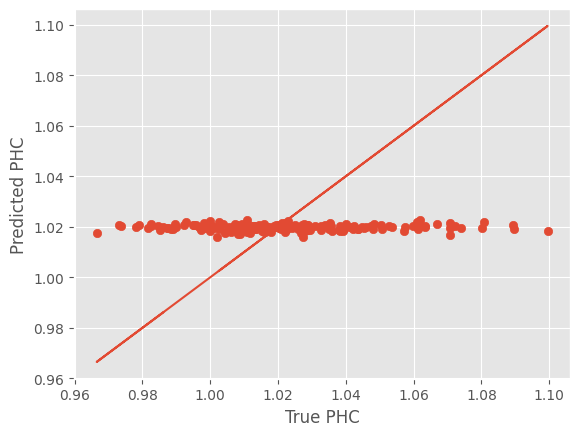

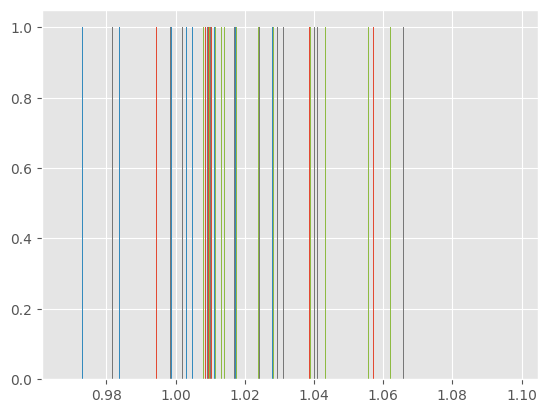

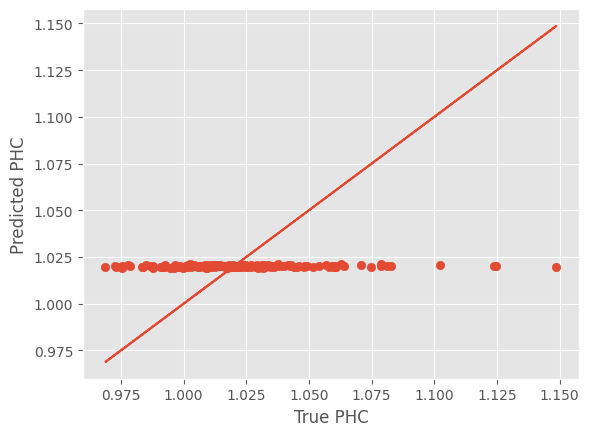

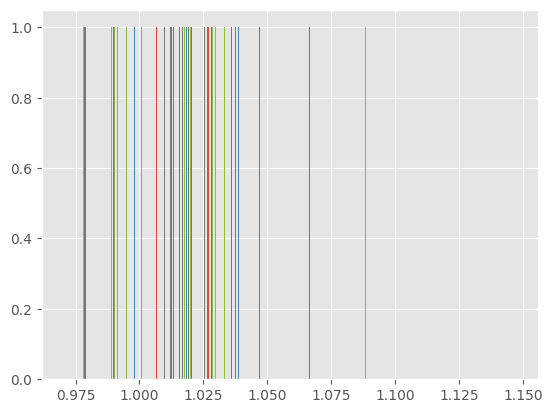

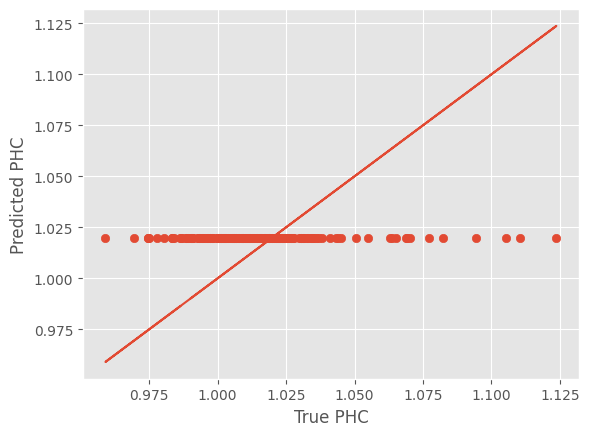

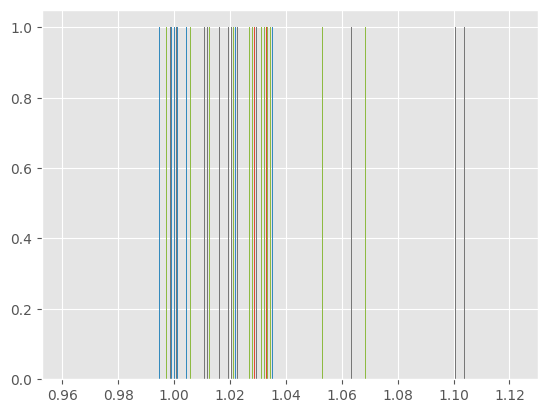

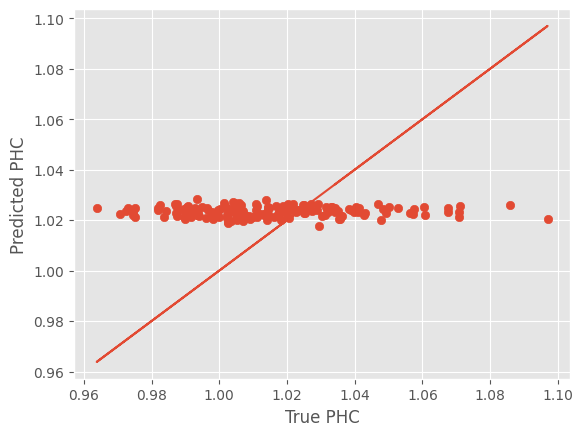

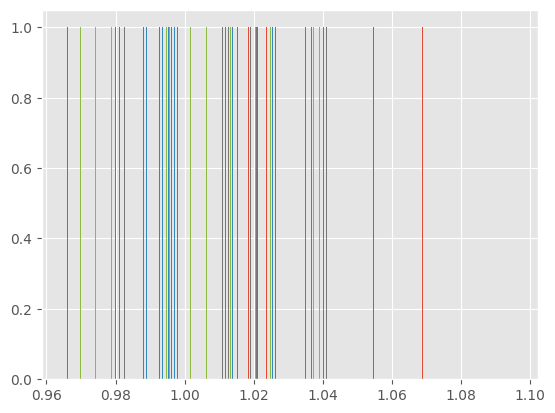

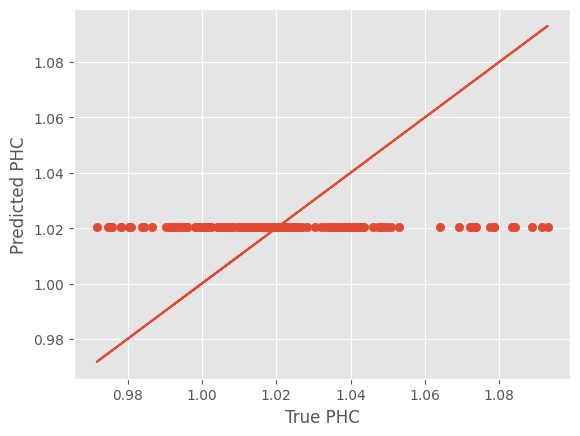

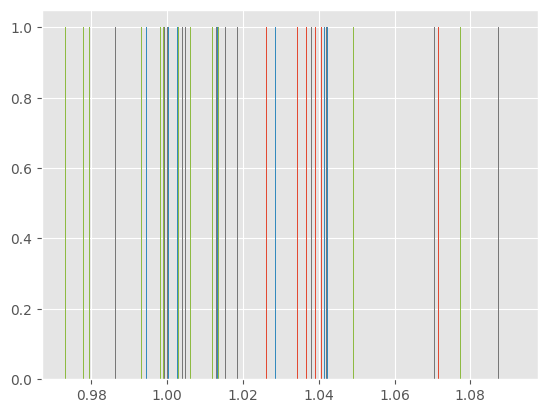

In [58]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

### Predicting CTX_RH_MIDDLETEMPORAL

#### Using Language (LAN) PHC Score

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 2.910182421548026
Epoch 5 loss 1.2963932148047856
Epoch 10 loss 0.6764049849339894
Epoch 15 loss 0.3613568689141955
Epoch 20 loss 0.20847323281424388
Epoch 25 loss 0.1331458908904876
Epoch 30 loss 0.10203397938166744
Epoch 35 loss 0.09152898544312588
Epoch 40 loss 0.08887040337680706
Epoch 45 loss 0.0883443422482482
Epoch 50 loss 0.0882127029588446
Epoch 55 loss 0.08863938716905458
Epoch 60 loss 0.08834399978763291
Epoch 65 loss 0.08826823169365525
Epoch 70 loss 0.08875135544554463
Epoch 75 loss 0.0882825124077499
Epoch 80 loss 0.09077962533171688
Epoch 85 loss 0.08826293874798076
Epoch 90 loss 0.08859896189533174
Epoch 95 loss 0.08855800610035658
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequen

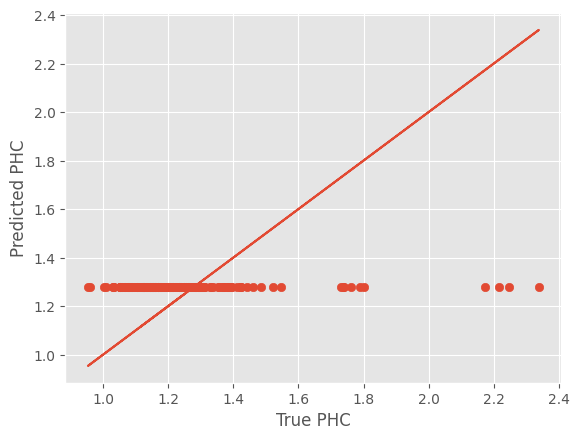

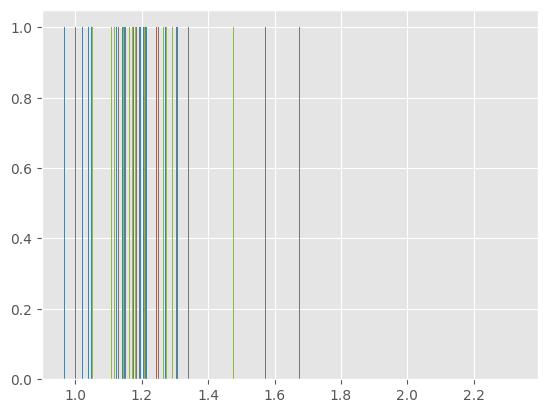

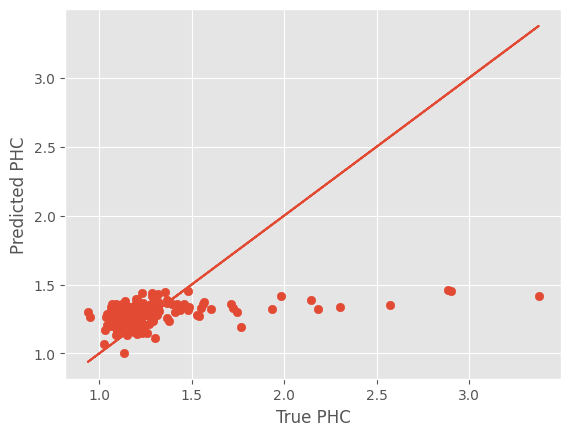

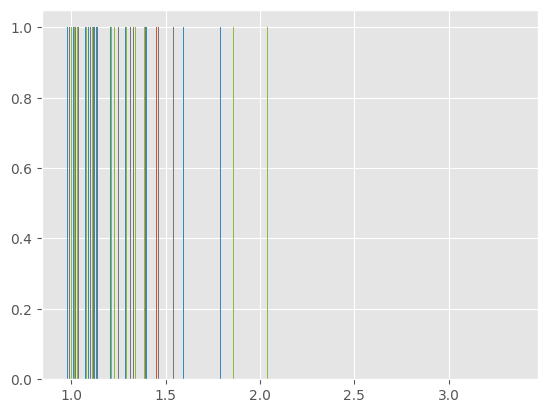

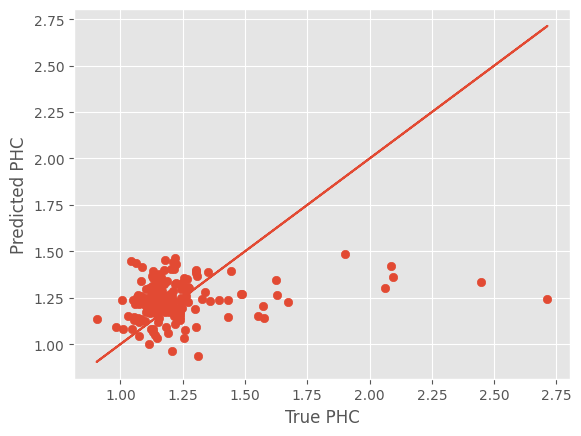

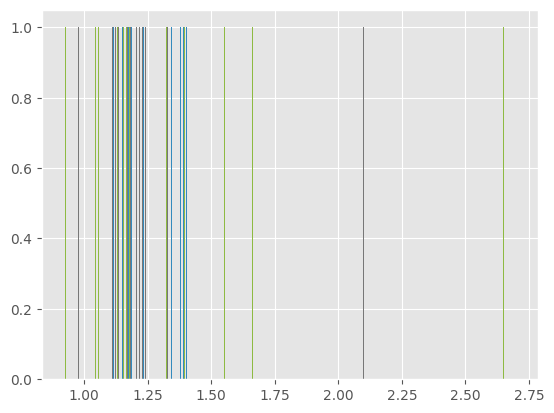

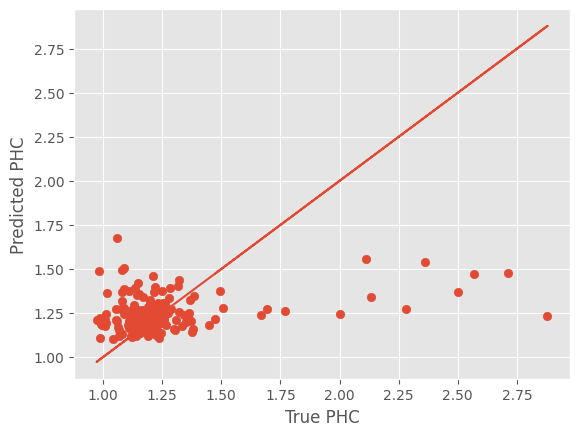

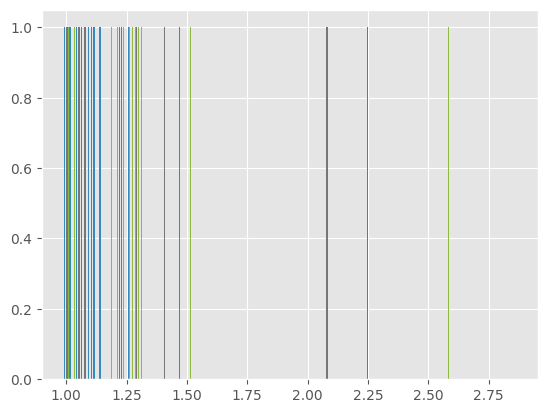

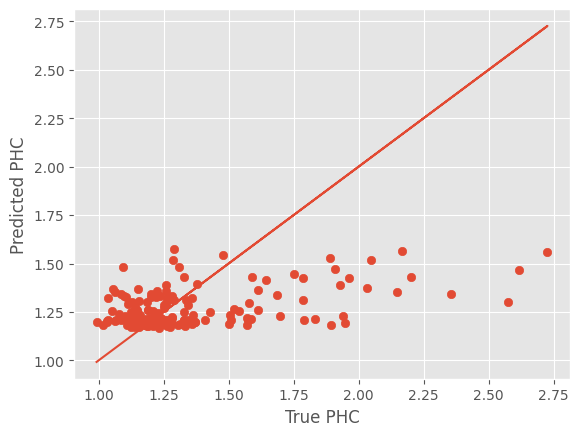

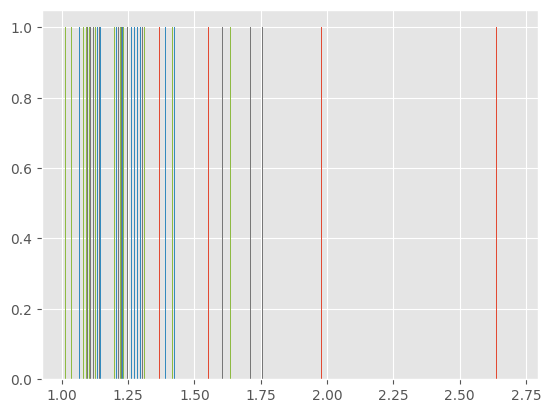

In [59]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
df['PHC_LAN_mannualJoin'] = stats.zscore(df['PHC_LAN_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

#### Using only ROI Volume

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 4.085186856133597
Epoch 5 loss 1.9523088455200195
Epoch 10 loss 0.4260947719216347
Epoch 15 loss 0.09337033463775048
Epoch 20 loss 0.078704958934603
Epoch 25 loss 0.07850247865010584
Epoch 30 loss 0.0784744649327227
Epoch 35 loss 0.0786609458204891
Epoch 40 loss 0.07843631940361645
Epoch 45 loss 0.07838637623935937
Epoch 50 loss 0.07850625520305975
Epoch 55 loss 0.0784171102102846
Epoch 60 loss 0.08122770940618855
Epoch 65 loss 0.0785940249849643
Epoch 70 loss 0.07851120691214289
Epoch 75 loss 0.07867321925503867
Epoch 80 loss 0.0785834732465446
Epoch 85 loss 0.07873044091143779
Epoch 90 loss 0.07850335432615663
Epoch 95 loss 0.07948421142729266
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequenti

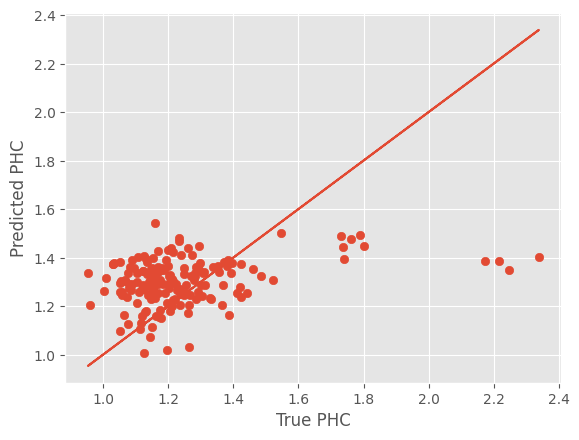

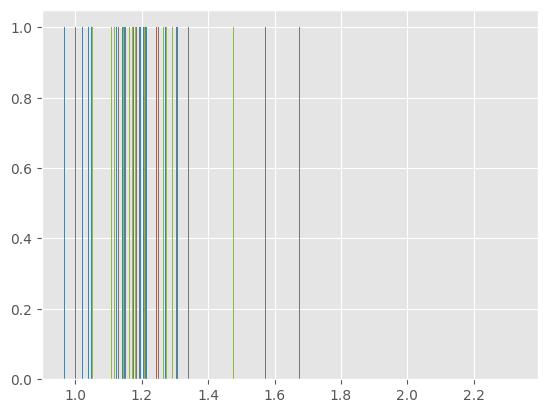

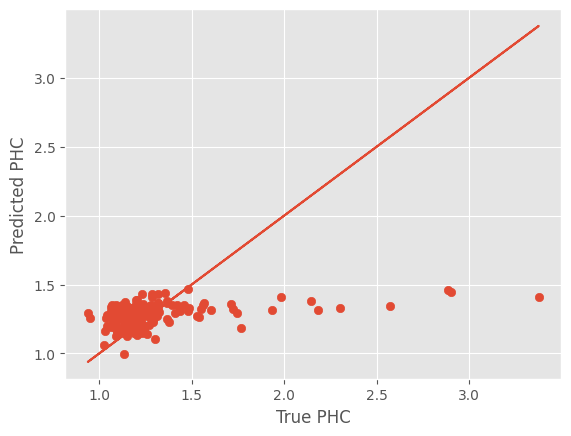

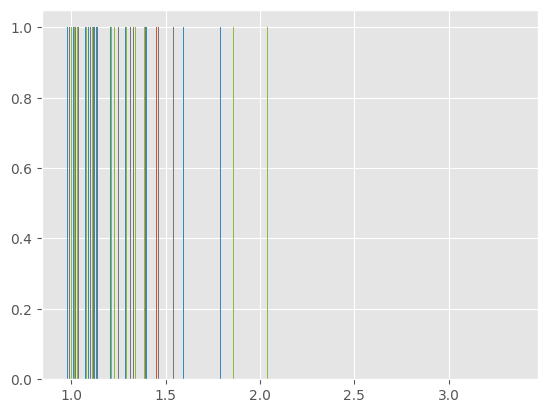

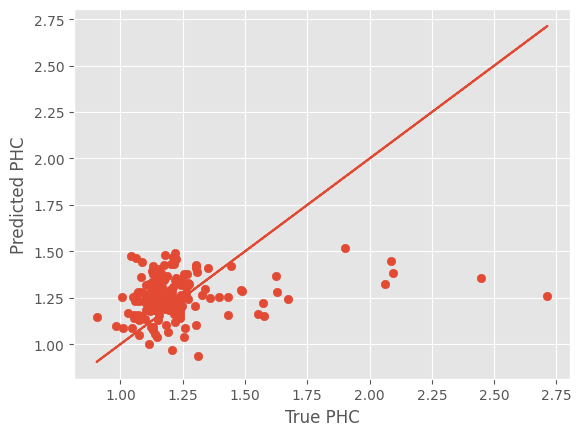

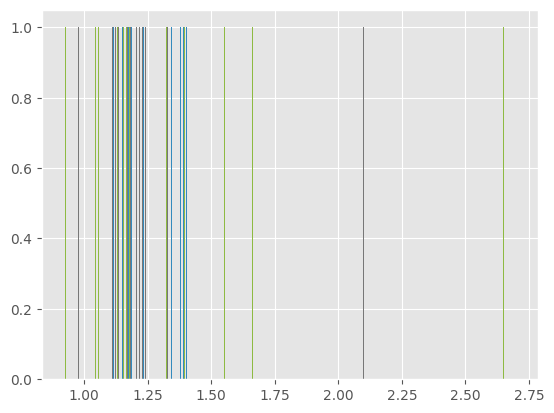

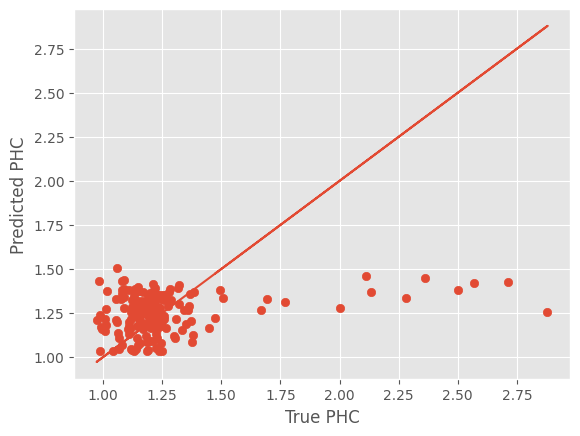

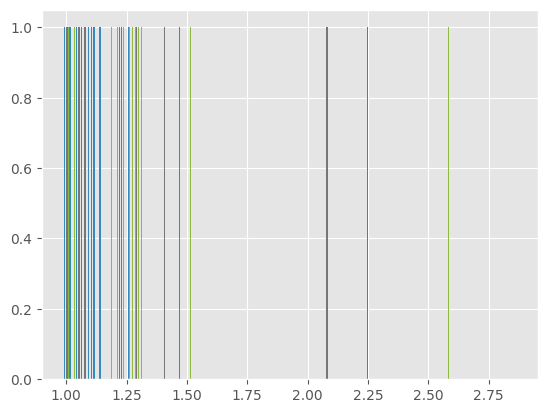

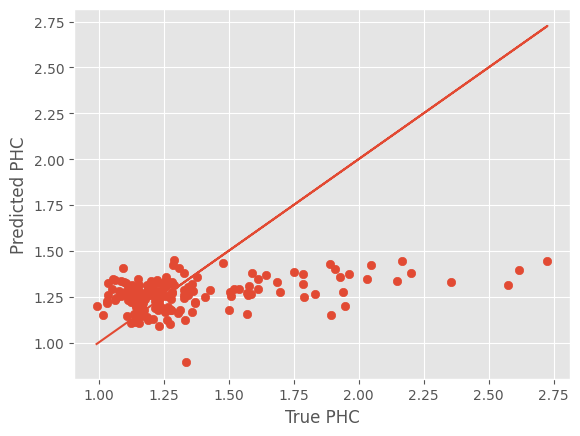

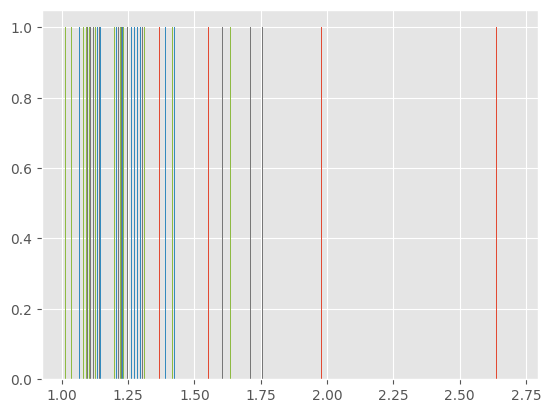

In [60]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

### Predicting CTX_RH_TEMPORALPOLE

#### Using Visuospatial (VSP) PHC Score

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.638255831173488
Epoch 5 loss 0.2932955128805978
Epoch 10 loss 0.0518576577704932
Epoch 15 loss 0.04270592707076243
Epoch 20 loss 0.04012358533218503
Epoch 25 loss 0.038855126589935805
Epoch 30 loss 0.03923202868817108
Epoch 35 loss 0.0382602385977017
Epoch 40 loss 0.03810664548405579
Epoch 45 loss 0.04036139897736055
Epoch 50 loss 0.037834866857987696
Epoch 55 loss 0.03796575785215412
Epoch 60 loss 0.0381086902692914
Epoch 65 loss 0.0380370307713747
Epoch 70 loss 0.03862533236055502
Epoch 75 loss 0.03812966146506369
Epoch 80 loss 0.03783866948714214
Epoch 85 loss 0.03766170117638207
Epoch 90 loss 0.03776529292309923
Epoch 95 loss 0.03787109402141401
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequen

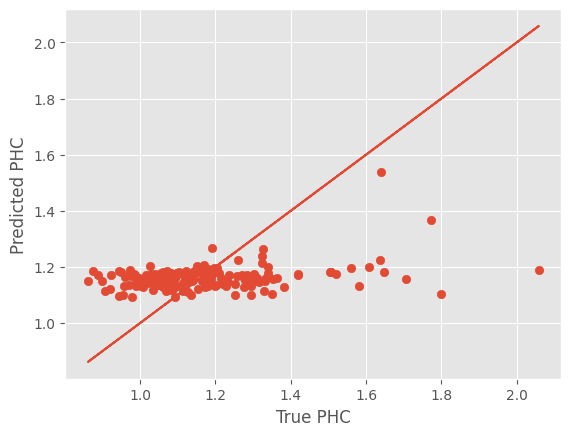

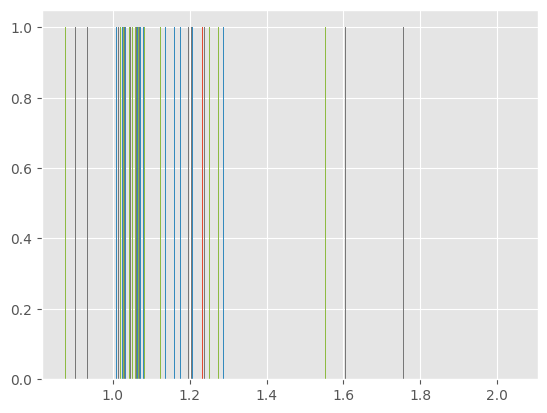

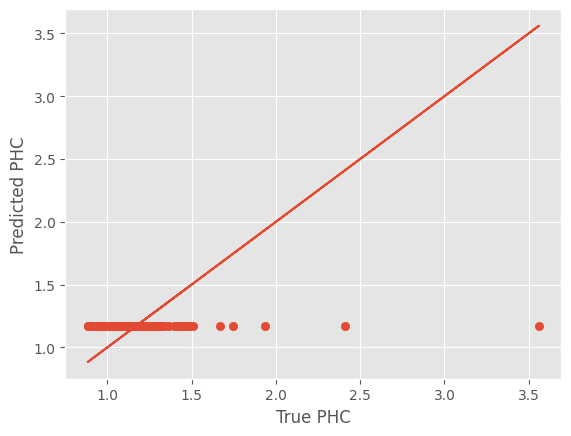

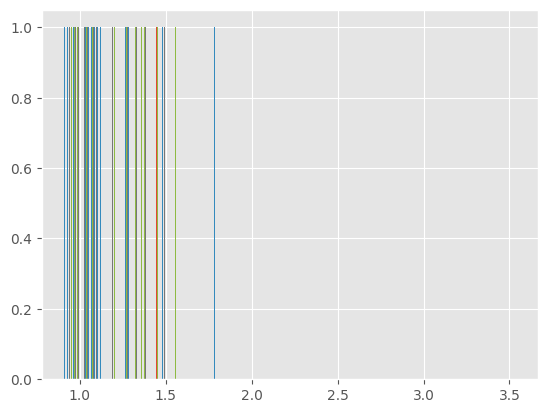

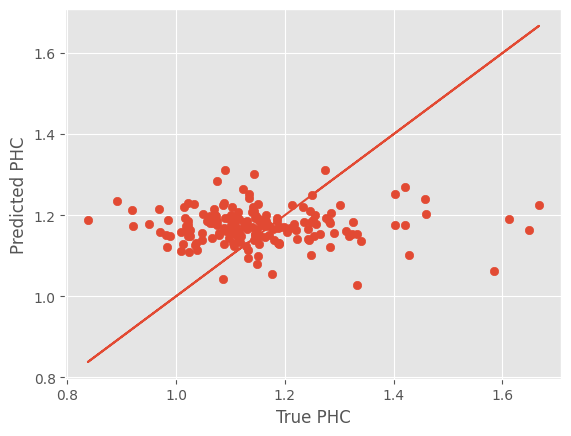

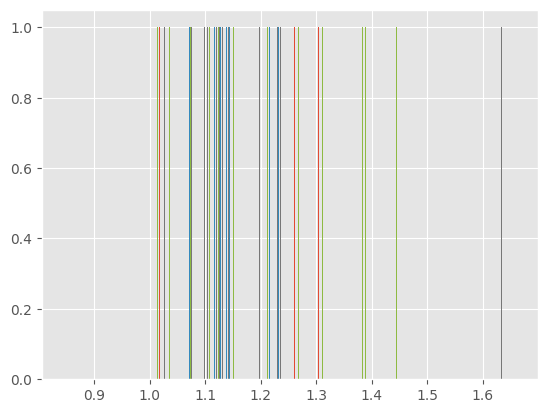

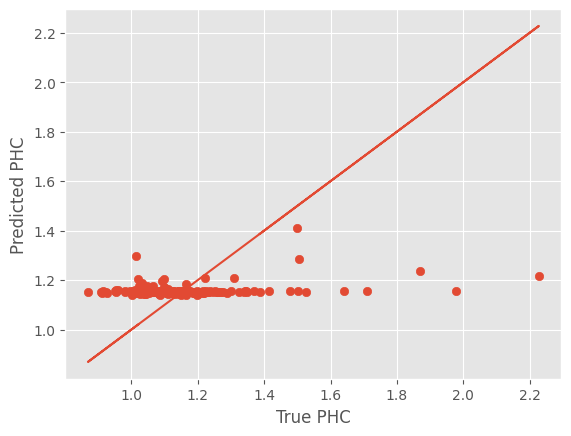

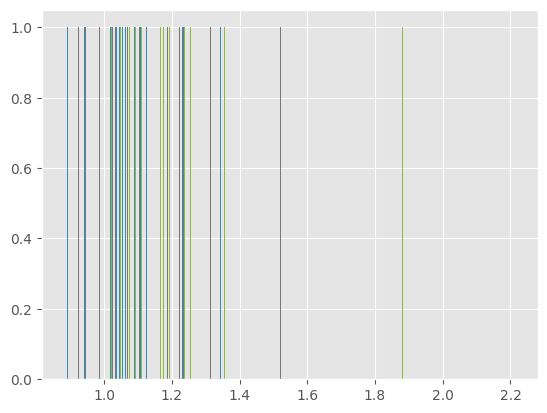

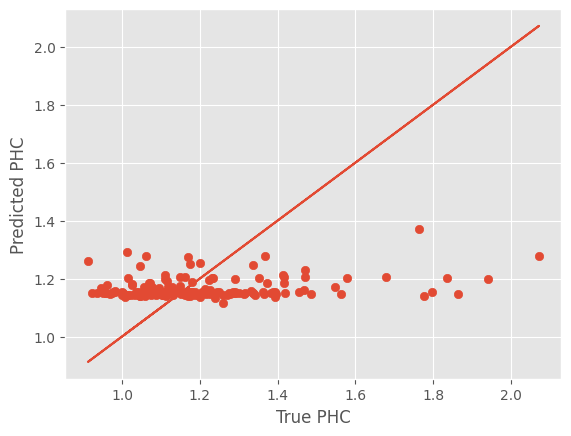

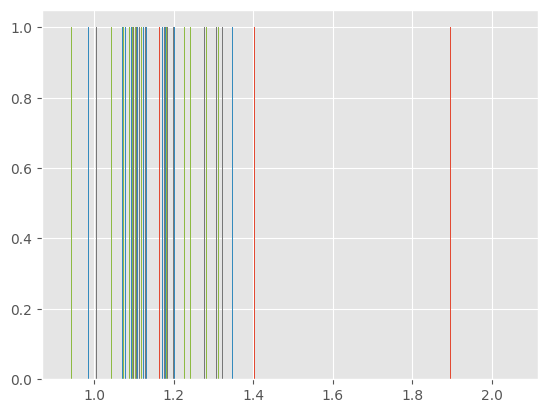

In [61]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

#### Using only ROI Volume

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.2118106646197182
Epoch 5 loss 0.6244429217917579
Epoch 10 loss 0.2944538086652756
Epoch 15 loss 0.13117624026324068
Epoch 20 loss 0.06569885334798269
Epoch 25 loss 0.045530454761215616
Epoch 30 loss 0.040096565904760996
Epoch 35 loss 0.03965212819665404
Epoch 40 loss 0.03935698055928307
Epoch 45 loss 0.0391427038137668
Epoch 50 loss 0.039190728962421414
Epoch 55 loss 0.03896910554197218
Epoch 60 loss 0.03929532299350415
Epoch 65 loss 0.039266109519771164
Epoch 70 loss 0.03899660856030615
Epoch 75 loss 0.03931271161085793
Epoch 80 loss 0.03897854008745136
Epoch 85 loss 0.03904559749311635
Epoch 90 loss 0.03916136170072215
Epoch 95 loss 0.0390096756829215
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Se

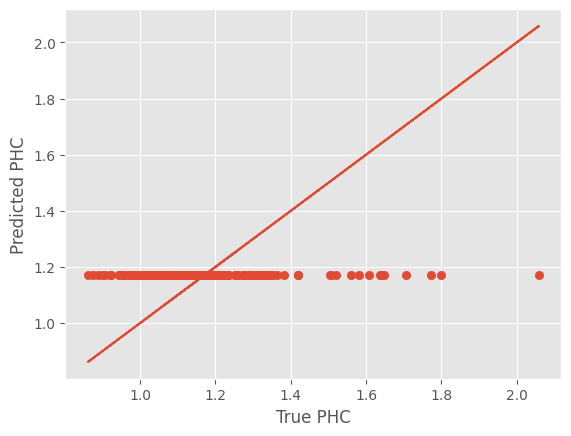

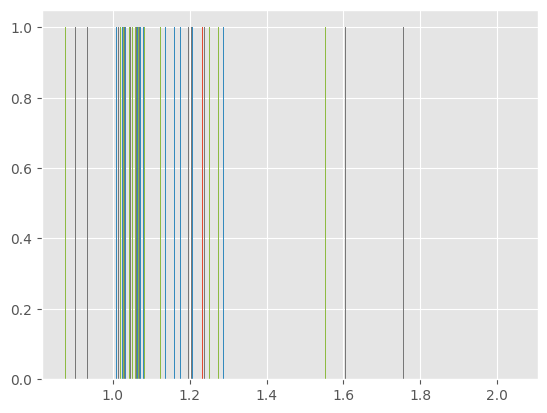

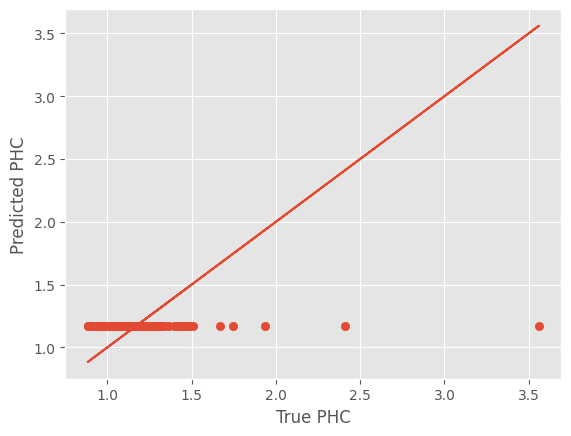

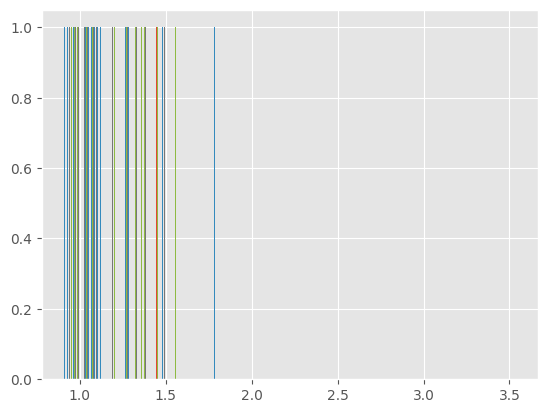

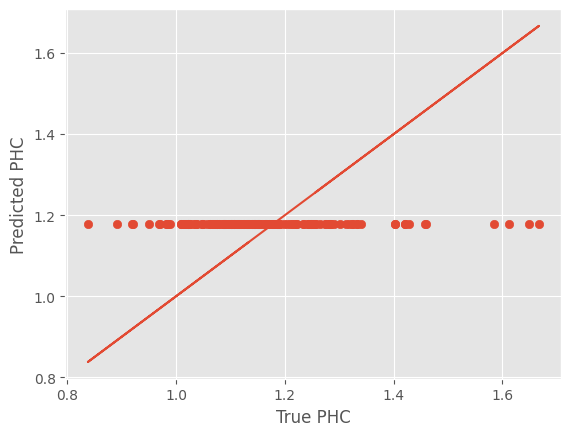

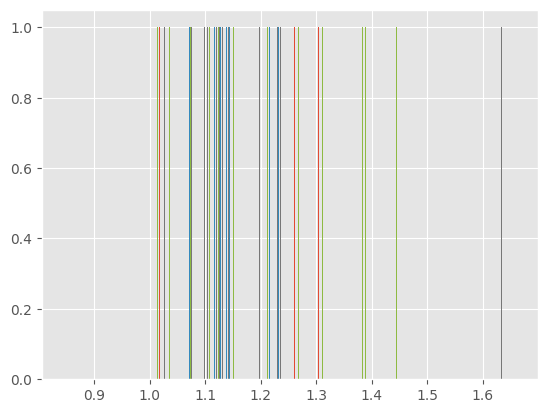

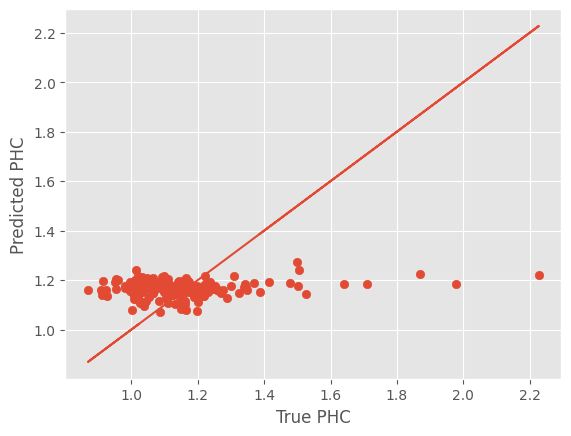

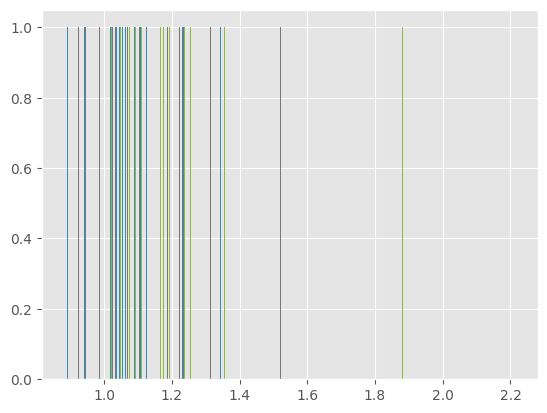

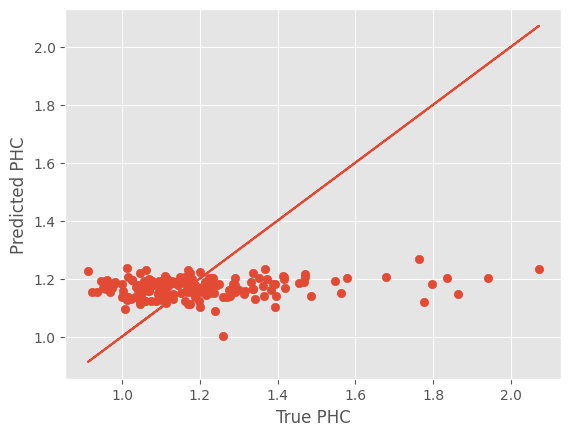

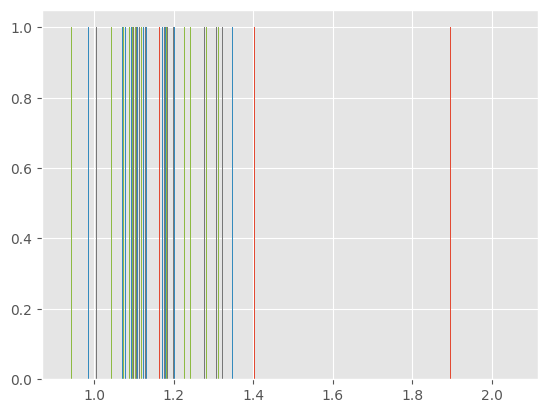

In [62]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

### Using SVMs to Predict SUVRs from PHC Scores and ROI Volumes

#### Predicting CTX_LH_PRECENTRAL with PHC MEM

0.12892221739780585
-0.04699901491759495
[-0.18863301  0.00374062 -0.02758111 -0.00499779 -0.01752379]
[0.11279102 0.14569256 0.10752152 0.13880567 0.13980031]


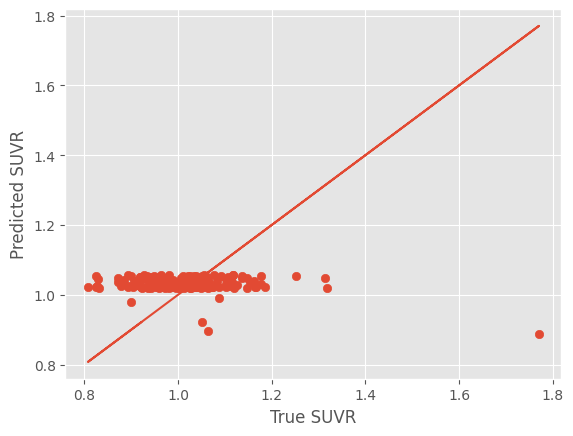

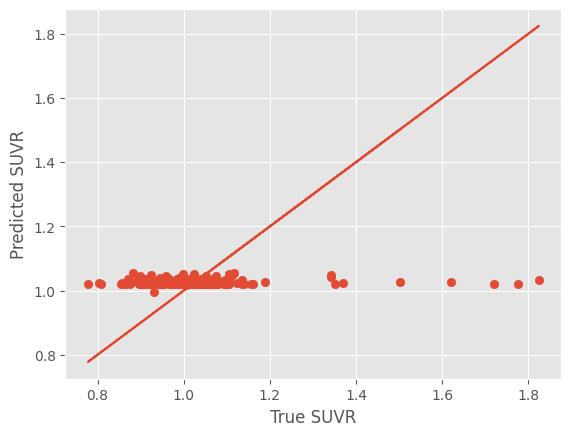

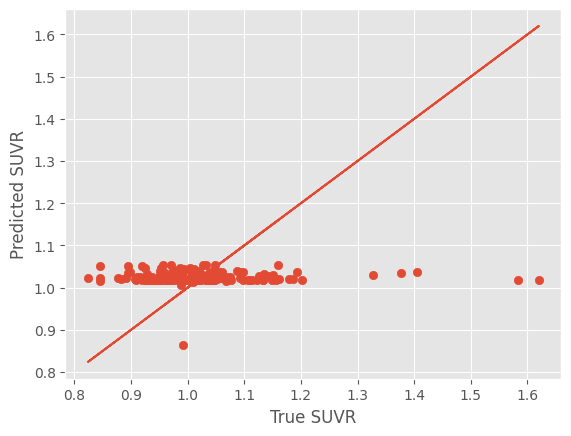

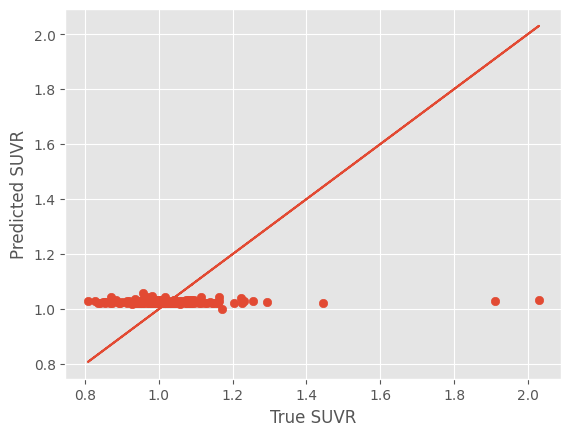

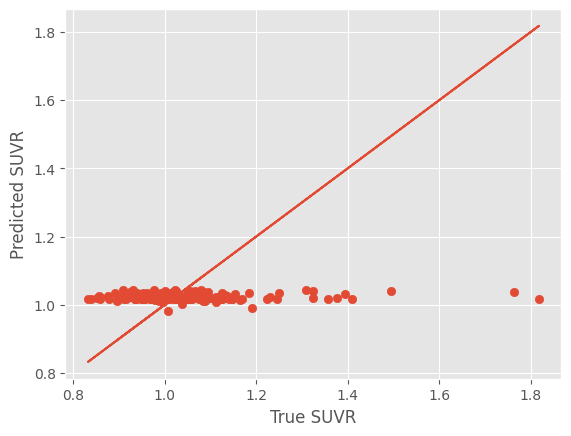

In [63]:
#PHC MEM
RMSE_SVM = np.zeros(5)
R2= np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

#### Predicting RIGHT_CEREBELLUM_CORTEX with PHC EXF

0.04500032969095405
-2.1161552831922785
[-1.91012726 -1.32617439 -2.53052414 -2.1823521  -2.63159852]
[0.04357685 0.03794029 0.0481291  0.04625112 0.04910429]


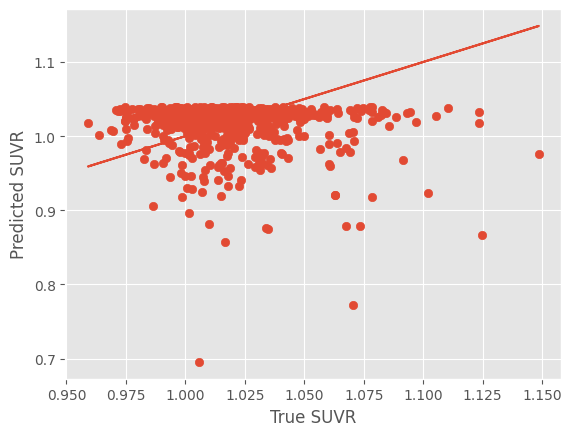

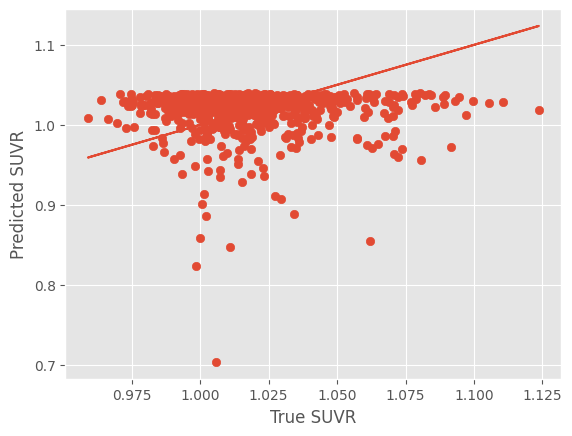

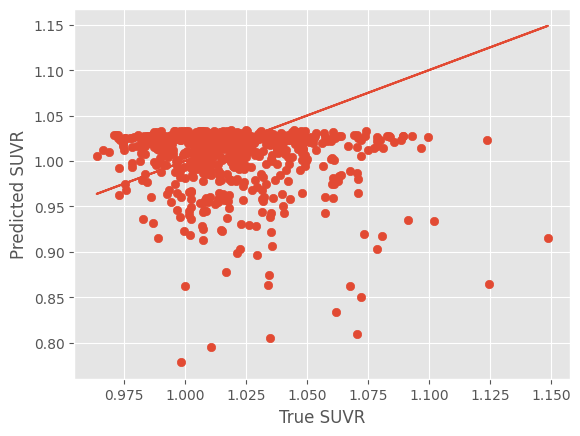

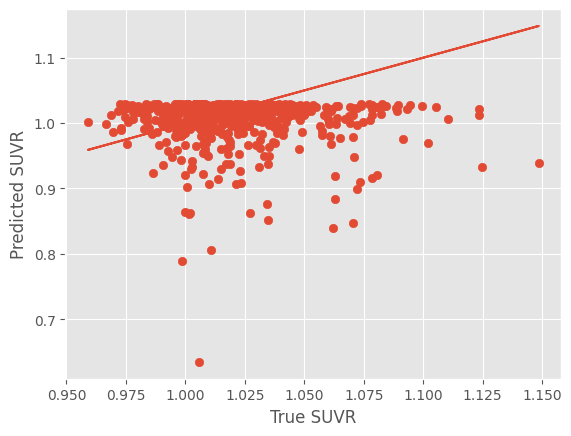

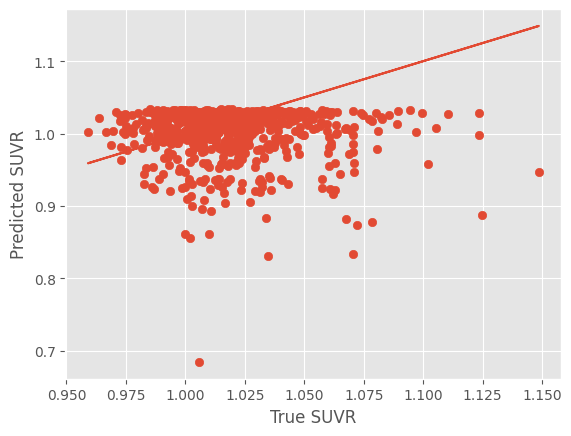

In [64]:
#PHC EXF
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
for i in range(5):
  if i==0:
    train_ds = df.iloc[(0):(+172)]
  train_ds = df.iloc[((i*172)):((i*172)+172)]
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

#### Predicting RH_MIDDLETEMPORAL with PHC LAN

0.2511183284998083
0.1635552693946631
[0.03604144 0.33169477 0.06185631 0.25235602 0.1358278 ]
[0.21081649 0.27064818 0.2203942  0.2587176  0.29501516]


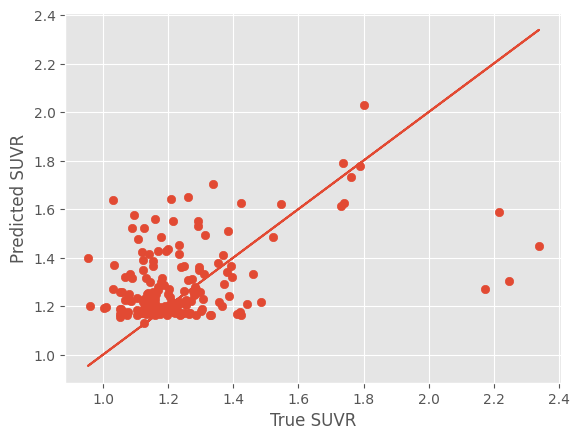

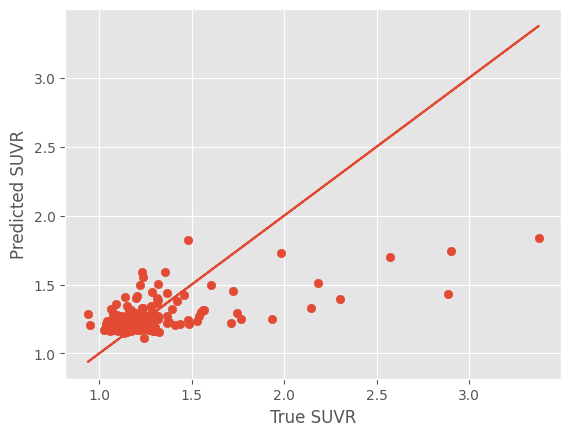

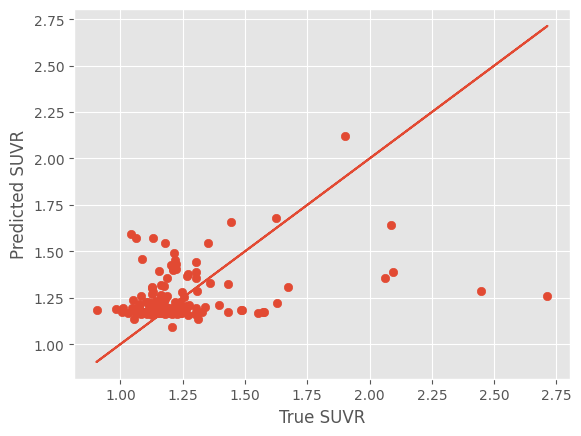

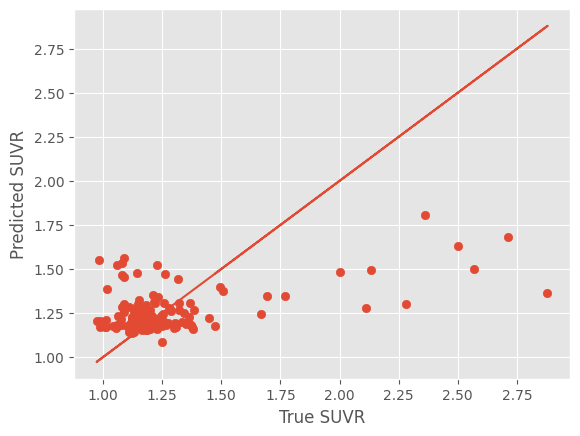

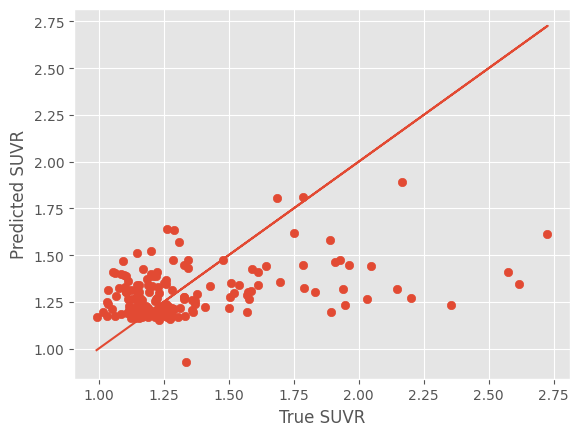

In [65]:
#PHC LAN
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

#### Predicting CTX_RH_TEMPORALPOLE with PHC VSP

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.1888958798011506
0.01257478108588701
[ 0.09927084  0.06916073 -0.14263933  0.04665194 -0.00957028]
[0.17943932 0.24938776 0.14118763 0.17451567 0.19994902]


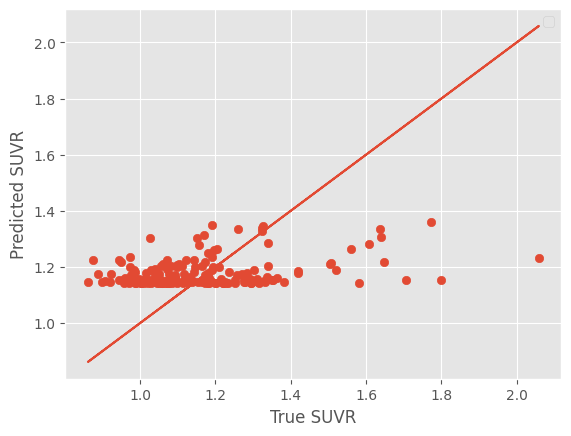

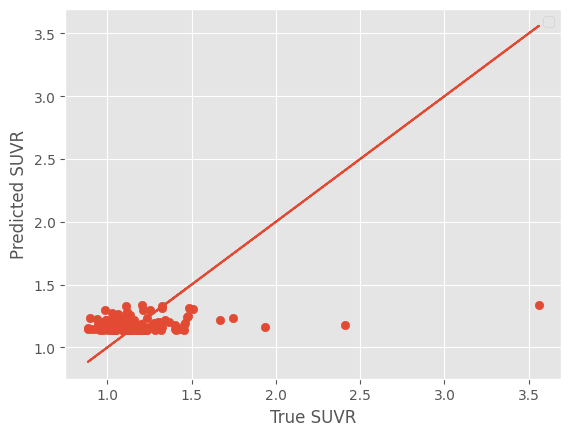

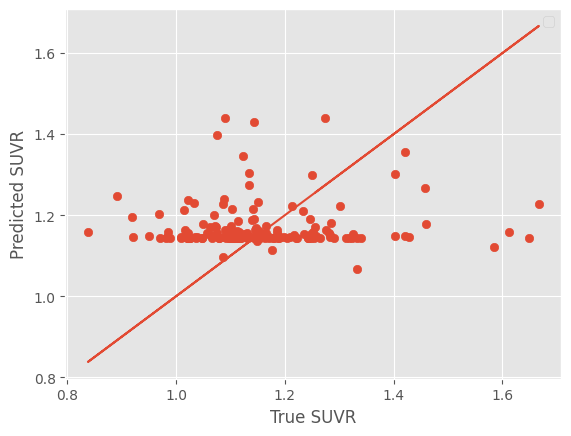

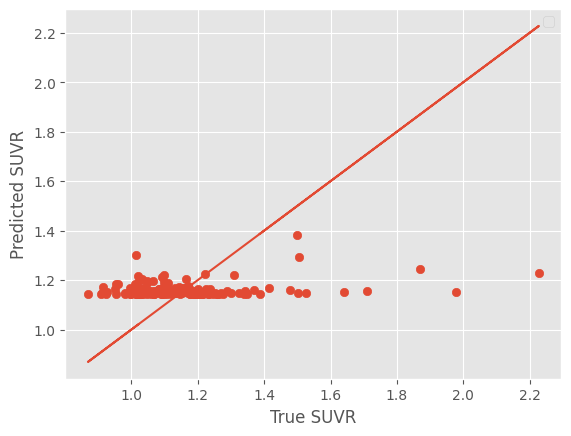

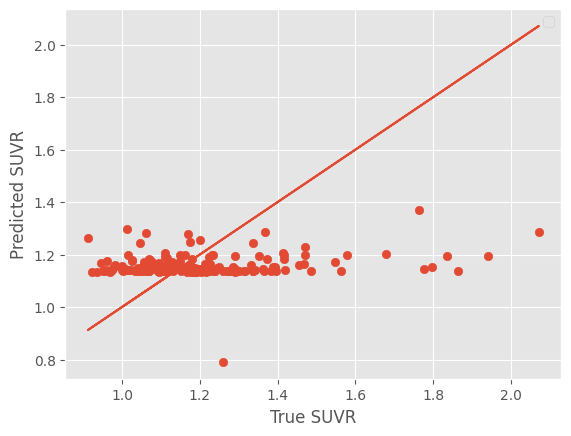

In [66]:
#PHC VSP
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
  plt.legend()
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

# Ranking ROIs

In [67]:
df_nn = df.drop(columns=['INFERIORCEREBELLUM_SUVR'])
df_nn = df_nn.fillna(0)

target_cols = [col for col in df_nn.columns if 'PHC' in col]
feature_cols = [col for col in df_nn.columns if '_SUVR' in col]
print(feature_cols)


['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL_SUVR', 'CTX_LH_POSTERIORCI

In [69]:
def run_NN(d, tc, fc, k = 5, rs = 20, lr = 0.001, nre = 100):
  ksplit = k
  RMSE_NN = np.zeros(ksplit)
  kf = KFold(n_splits=ksplit, shuffle=True, random_state=rs)   # setting random_state for repeatable results

  train_folds = []
  test_folds = []

  for i, (train, test) in enumerate(kf.split(d)):
      train_folds.append(d.iloc[train])
      test_folds.append(d.iloc[test])

  # Run Model
  for i in range(ksplit):
    train_ds = train_folds[i]
    test_ds = test_folds[i]
    input_size = 118
    batch_size = 10
    train_pt_ds = PandasDataset(train_ds, feature_cols=fc, target_col=tc)
    test_pt_ds = PandasDataset(test_ds, feature_cols=fc, target_col=tc)
    train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
    test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
    model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
    print(model)
    learning_rate = lr
    nr_epochs = nre
    eval_every = 5
    loss_f = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
    RMSE_NN[i]= eval_model_historic(model,test_dl)
    print("RMSE for Epoch " + str(i) + " : " + str(eval_model_historic(model,test_dl)))
  return model, np.mean(RMSE_NN)

In [70]:
standardModel, rmseVal = run_NN(df_nn, target_cols, feature_cols, k = 4)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.48381441602340114
Epoch 5 loss 0.46534673158939066
Epoch 10 loss 0.45721600560041575
Epoch 15 loss 0.4593748069726504
Epoch 20 loss 0.46173004737267126
Epoch 25 loss 0.4578046977519989
Epoch 30 loss 0.45633813922221844
Epoch 35 loss 0.4595090049963731
Epoch 40 loss 0.4555355571783506
Epoch 45 loss 0.459983682173949
Epoch 50 loss 0.4545825738173265
Epoch 55 loss 0.45309774508843054
Epoch 60 loss 0.4563781316463764
Epoch 65 loss 0.45538595227094797
Epoch 70 loss 0.45539906804378216
Epoch 75 loss 0.453921914100647
Epoch 80 loss 0.45308330517548784
Epoch 85 loss 0.4535776725182166
Epoch 90 loss 0.4548817483278421
Epoch 95 loss 0.4556652036996988
Finished training!
[array([0.18281332], dtype=float32), array([-0.02250546], dtype=float32), array([0.26991457], dtype=flo

In [71]:
print(standardModel)
for param in standardModel.parameters():
  params = (param.data.numpy())
  break
max = np.zeros(4)
importance = np.zeros((4,len(feature_cols)))
print(feature_cols)
print(len(feature_cols))
print(params.shape)
ROIS = []
for i in range(4):
  max[i] = np.max(params[i,:])
  k= np.argmax(params[i,:])
  sorted_pos = np.argsort(params[i,:])
  print(feature_cols[112])
  for j in range(len(feature_cols)):
    importance[i, j] = list(sorted_pos).index(j)
  ROIS.append(feature_cols[k])

pos_mean = np.zeros(len(feature_cols))
pos_std = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  pos_mean[i] = np.mean(importance[:,i])
  pos_std[i] = np.std(importance[:,i])
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))
print(ROIS)
print(target_cols)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARA

In [72]:
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))

CC_ANTERIOR_SUVR: Mean = 15.0, Standard Deviation = 15.215124054702938, Importance = [41. 10.  3.  6.]
LEFT_INF_LAT_VENT_SUVR: Mean = 16.25, Standard Deviation = 13.045593125649749, Importance = [32.  1.  6. 26.]
CTX_RH_TRANSVERSETEMPORAL_SUVR: Mean = 18.25, Standard Deviation = 12.457427503300993, Importance = [ 4. 13. 18. 38.]
CC_MID_ANTERIOR_SUVR: Mean = 25.0, Standard Deviation = 39.881073205218534, Importance = [94.  0.  1.  5.]
CTX_LH_BANKSSTS_SUVR: Mean = 26.0, Standard Deviation = 19.862024066041204, Importance = [12. 59. 24.  9.]
BRAINSTEM_SUVR: Mean = 26.25, Standard Deviation = 10.940178243520533, Importance = [13. 41. 19. 32.]
ERODED_SUBCORTICALWM_SUVR: Mean = 29.5, Standard Deviation = 34.630189141845584, Importance = [ 7. 88. 22.  1.]
RIGHT_LATERAL_VENTRICLE_SUVR: Mean = 29.5, Standard Deviation = 18.728320800328042, Importance = [47. 49.  7. 15.]
RIGHT_PUTAMEN_SUVR: Mean = 29.75, Standard Deviation = 16.723860200324566, Importance = [29. 27. 55.  8.]
CTX_LH_PARACENTRAL_S

# Classifiers for each PHC Score

In [73]:
fs_overall = [None] * len(feature_cols)
fs_mem = [None] * len(feature_cols)
fs_exf = [None] * len(feature_cols)
fs_lan = [None] * len(feature_cols)
fs_vsp = [None] * len(feature_cols)

vols_overall = [None] * len(feature_cols)
vols_mem = [None] * len(feature_cols)
vols_exf = [None] * len(feature_cols)
vols_lan = [None] * len(feature_cols)
vols_vsp = [None] * len(feature_cols)

for i in np.argsort(pos_mean):
  fs_overall[i] = feature_cols[i]
  vols_overall[i] = fs_overall[i].replace('_SUVR', '_VOLUME')


for i in range(len(feature_cols)):
  fs_mem[i] = feature_cols[int(importance[0, i])]
  vols_mem[i] = fs_mem[i].replace('_SUVR', '_VOLUME')
  fs_exf[i] = feature_cols[int(importance[1, i])]
  vols_exf[i] = fs_exf[i].replace('_SUVR', '_VOLUME')
  fs_lan[i] = feature_cols[int(importance[2, i])]
  vols_lan[i] = fs_lan[i].replace('_SUVR', '_VOLUME')
  fs_vsp[i] = feature_cols[int(importance[3, i])]
  vols_vsp[i] = fs_vsp[i].replace('_SUVR', '_VOLUME')
print(target_cols)

['PHC_MEM_mannualJoin', 'PHC_EXF_mannualJoin', 'PHC_LAN_mannualJoin', 'PHC_VSP_mannualJoin']


In [74]:
df_classifier_train = df_nn.sample(frac=0.8)
df_classifier_test = df_nn.drop(df_classifier_train.index)

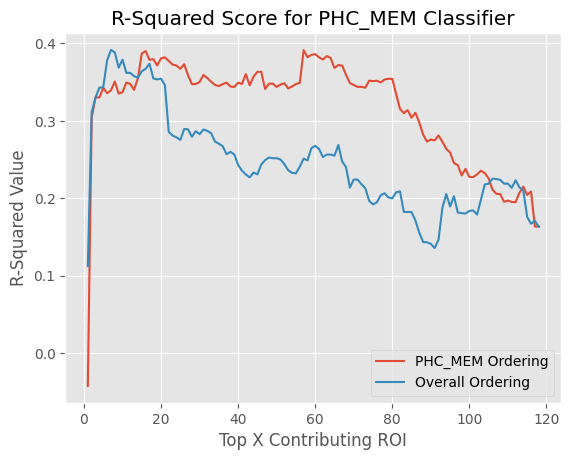

56
0.39135209938555027
6
0.39158042822278194


In [75]:
# MEM PHC Classifier
import pandas
from sklearn import linear_model, metrics

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_mem_m = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_mem[0:i+1] + vols_mem[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_mem[0:i+1] + vols_mem[0:i+1]])
  r2_arr_mem_m[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)

r2_arr_mem_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_mem_o[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_mem_m, label = "PHC_MEM Ordering")
plt.plot(list(range(1, 119)), r2_arr_mem_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_MEM Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_mem_m.argmax())
print(r2_arr_mem_m.max())
print(r2_arr_mem_o.argmax())
print(r2_arr_mem_o.max())

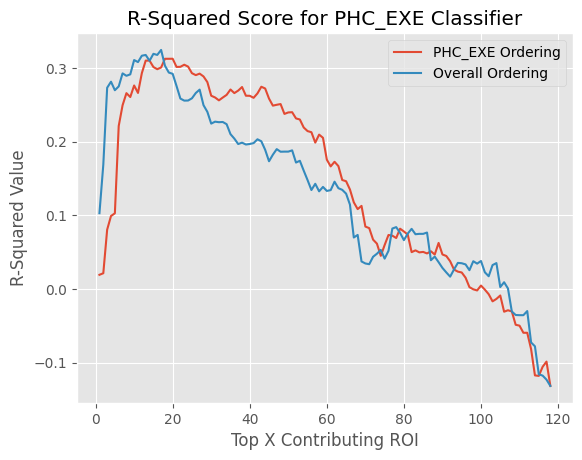

19
0.3126412598542354
16
0.3246169225865966


In [76]:
# EXF PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_exf_e = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_exf[0:i+1] + vols_exf[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_exf[0:i+1] + vols_exf[0:i+1]])
  r2_arr_exf_e[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)

r2_arr_exf_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_exf_o[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_exf_e, label = "PHC_EXE Ordering")
plt.plot(list(range(1, 119)), r2_arr_exf_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_EXE Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_exf_e.argmax())
print(r2_arr_exf_e.max())
print(r2_arr_exf_o.argmax())
print(r2_arr_exf_o.max())

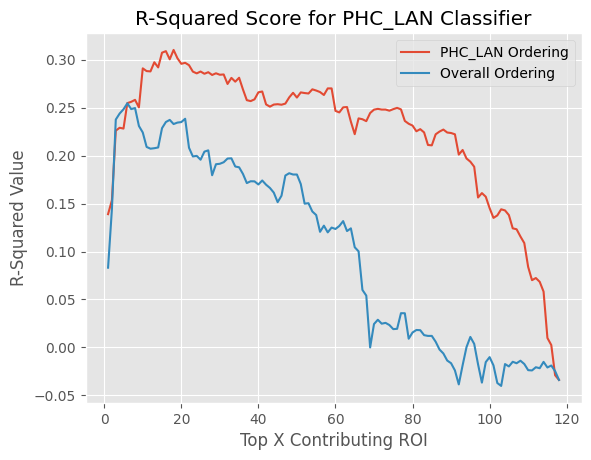

17
0.31010083267800925
5
0.2544844289584286


In [77]:
# LAN PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_lan_l = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_lan[0:i+1] + vols_lan[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_lan[0:i+1]+vols_lan[0:i+1]])
  r2_arr_lan_l[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)

r2_arr_lan_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_lan_o[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_lan_l, label = "PHC_LAN Ordering")
plt.plot(list(range(1, 119)), r2_arr_lan_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_LAN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_lan_l.argmax())
print(r2_arr_lan_l.max())
print(r2_arr_lan_o.argmax())
print(r2_arr_lan_o.max())

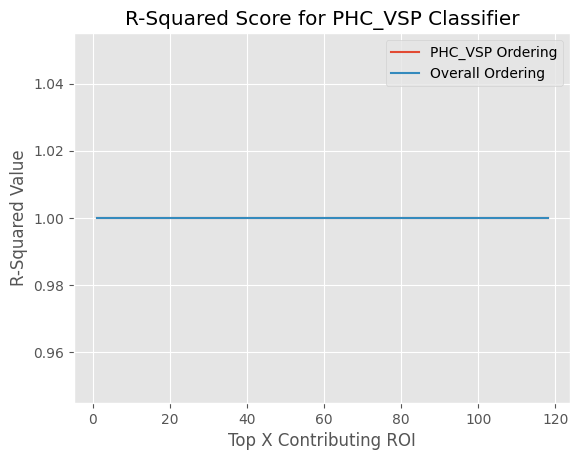

0
1.0
0
1.0


In [78]:
# VSP PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_vsp_v = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_vsp[0:i+1] + vols_vsp[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_vsp[0:i+1] + vols_vsp[0:i+1]])
  r2_arr_vsp_v[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)

r2_arr_vsp_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_vsp_o[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_vsp_v, label = "PHC_VSP Ordering")
plt.plot(list(range(1, 119)), r2_arr_vsp_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_VSP Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_vsp_v.argmax())
print(r2_arr_vsp_v.max())
print(r2_arr_vsp_o.argmax())
print(r2_arr_vsp_o.max())

# CN/MCI-AD Classifier

In [79]:
cognitionDF = pd.concat([df_nn[df_nn['dx_current.tau'] == 'CN'], df_nn[df_nn['dx_current.tau'] == 'MCI-AD']])
cognitionDF['dx_current.tau'].replace('CN', 0, inplace=True)
cognitionDF['dx_current.tau'].replace('MCI-AD', 1, inplace=True)
cognitionDF_train = cognitionDF.sample(frac=0.8)
cognitionDF_test = cognitionDF.drop(cognitionDF_train.index)

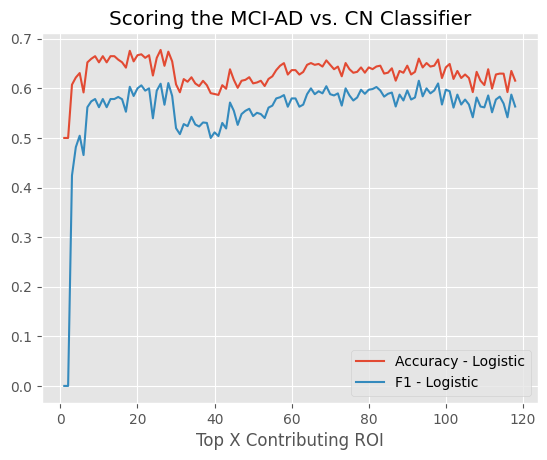

25
0.6775075987841945
92
0.6153846153846154


In [80]:
import pandas
from sklearn import linear_model, metrics

f1_cognitionLog = np.zeros(len(feature_cols))
accuracy_cognitionLog = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  cogntion_regr = linear_model.LogisticRegression()
  cogntion_regr.fit(cognitionDF_train[fs_overall[0:i+1] + vols_overall[0:i+1]], cognitionDF_train['dx_current.tau'])
  prediction = cogntion_regr.predict(cognitionDF_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  # print('Prediction:')
  # print(prediction)
  # print('Truth:')
  # print(cognitionDF_test['dx_current.tau'].to_numpy())
  f1_cognitionLog[i] = metrics.f1_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
  accuracy_cognitionLog[i] = metrics.balanced_accuracy_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
plt.plot(list(range(1, 119)), accuracy_cognitionLog, label="Accuracy - Logistic")
plt.plot(list(range(1, 119)), f1_cognitionLog, label="F1 - Logistic")
plt.title("Scoring the MCI-AD vs. CN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.legend()
plt.show()
print(accuracy_cognitionLog.argmax())
print(accuracy_cognitionLog.max())
print(f1_cognitionLog.argmax())
print(f1_cognitionLog.max())